## <b>Summary</b>

1. Load Time Series Data<br> 
    <b>Customer Volumes</b>: Read target value Customer Volumes. There are 99 months historial Customer Volumes data. The goal is to forecast next 18 month customer volumes with selected leading indexes.<br> 
    <b>Indexes</b>: Provided with 99 historical months and next 18 months indexes data with three different values, IDX1, IDX2,IDX3. 
2. Data Visualization<br>
    <b>Decompostion Plot</b>: Decomposed Customer Volumes into Trend, Seasonal and residuals plot. Observed yearly seasonality, the demand increases to a peak on April and has the lowest demand at end of each year.<br> 
    <b>Series plot with line</b>: Predefined 6 date lines based on observed multiples peaks. Examined whether each index have lead/lag relationship with cutomer volumes at the particular peak values.<br>
    IDX1: 
    IDX2:
    IDX3:
3. Stationary Test:<br>
    Merged customer volumes and indexes data, then split it into train (81) and test(18). Applied Augmented Dickey-Fuller Test (ADF Test) to examine if the time series are all stationary.Since IDX1,IDX2,IDX3 are non-stationary data, applied first order difference to transform data, repeat with another ADF test, now all the columns are staionary. <br>
4. Granger Causality test:<br>
    Used Granger Causality Test to investigate which of the indices provided are leading indicators. A Granger's causality test tells us if one or more time series (IDX1, IDX2, and IDX3) causes another time series (customer volume). Granger's causality test is one way of finding leading indicators for time series analysis <br>
5. Apply Time Series Model:<br>
   <b>VAR</b>: ~19% <br>
   <b>FBProphet</b>: MAPE  ~ 8% <br>
   <b>SARIMAX</b>:<br>
6. Parameters Tuning<br>
7. Evaluated Models<br>
8. Forecast on the 18 month<br>

    
    
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime
from scipy import stats
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math 
import warnings
warnings.filterwarnings('ignore')
import itertools

### Load Data 

In [2]:
#Customer Volumes data
customer_volumes = pd.read_excel('Data Challenge.xlsx', sheet_name='Customer Historical Volumes', engine='openpyxl')
#Cleaning the dates column
customer_volumes['Month'] = pd.to_datetime(customer_volumes['Month'], format='%Y%m')
print('historical_customer_volumes from {} to {}'.format(customer_volumes['Month'].min(), customer_volumes['Month'].max()))

historical_customer_volumes from 2011-01-01 00:00:00 to 2019-03-01 00:00:00


In [3]:
#Indexes Data
indexes = pd.read_excel('Data Challenge.xlsx', sheet_name='Indexes', engine='openpyxl').dropna(how='all', axis='columns')
#Cleaning the dates column
indexes['Month'] = pd.to_datetime(indexes['Month'], format='%Y%m')
print('indexes data from {} to {}'.format(indexes['Month'].min(), indexes['Month'].max()))

indexes data from 2011-01-01 00:00:00 to 2020-09-01 00:00:00


In [4]:
#Merge Data
df = pd.concat([customer_volumes,indexes],axis=1).dropna()
df = df.loc[:,~df.columns.duplicated()]
df = df.set_index('Month')
df = df[['Customer Volumes','IDX1','IDX2','IDX3']]

### Quick Visualization

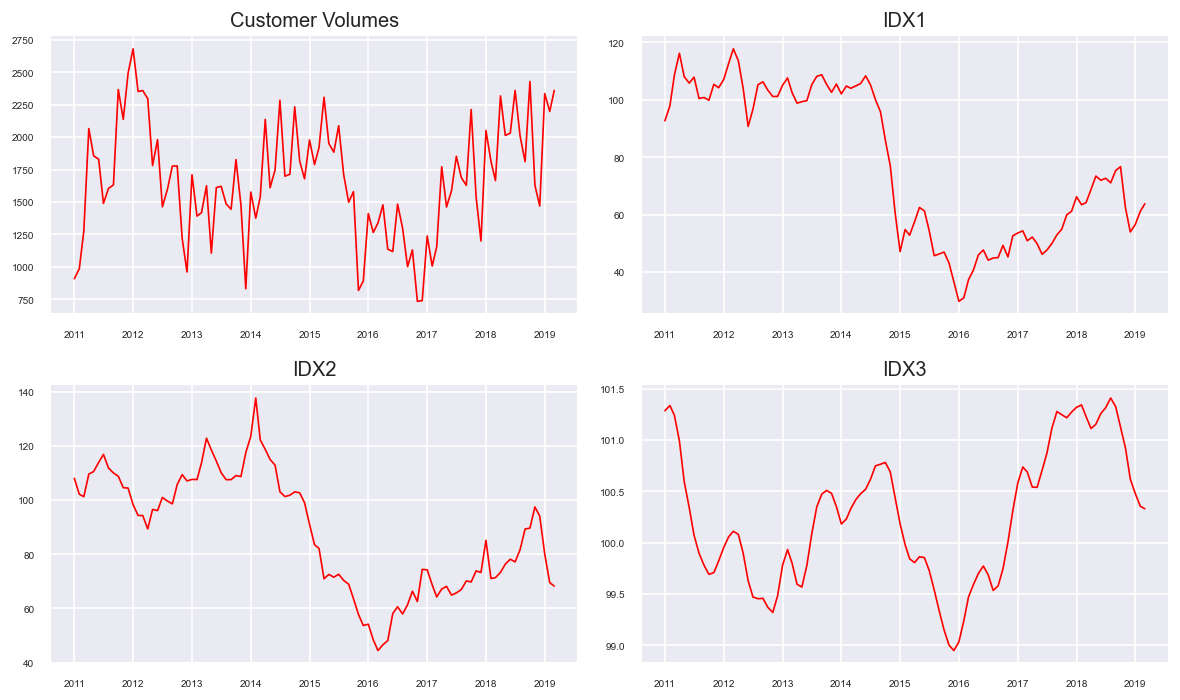

In [5]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

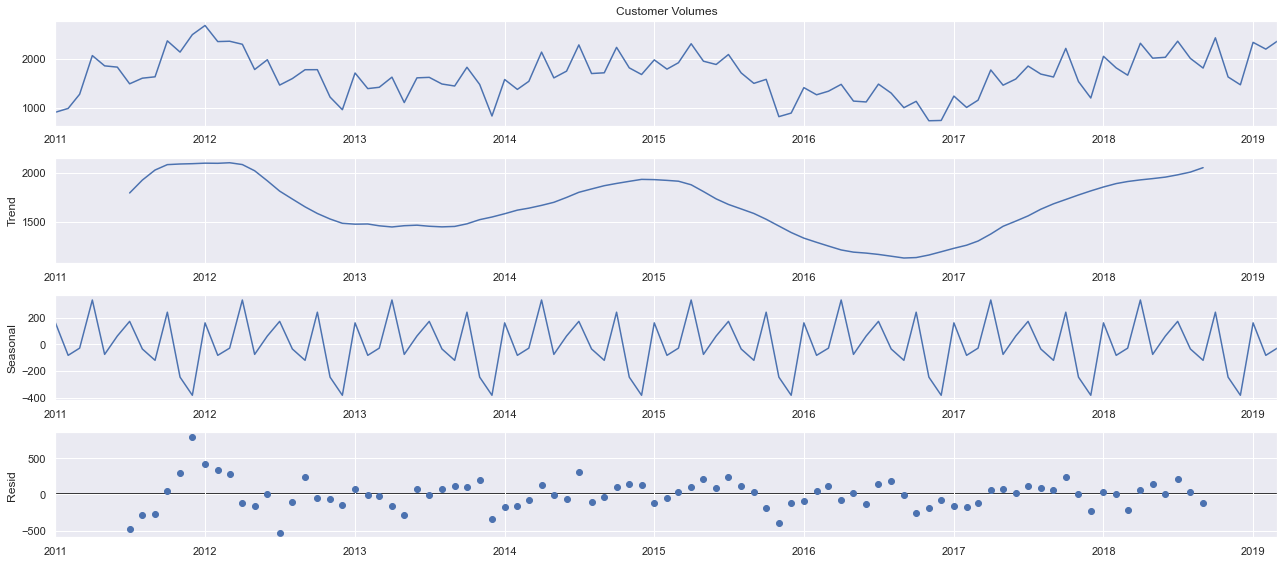

In [6]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df['Customer Volumes'], model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
def DoLinePlot_wVLines():
    #df = df.loc[df['Date'] >= StartYear].copy()
    data = df[[Series1,Series2]]
    #data = data.set_index('Date').resample('Q').mean()
    sns.set(font_scale=1.5)
    x = data.index
    y = data[Series1]
    y1 = data[Series2]
    fig, ax1 = plt.subplots(figsize = (15,7.5))
    ax2 = ax1.twinx()
    ax1.plot(x, y)
    ax2.plot(x, y1, color="red" )
    ax1.set_xlabel('Dateline')
    ax1.set_ylabel(Series1, color='b')
    ax2.set_ylabel(Series2, color='r')
    fig.autofmt_xdate()
 
    # plot inflection points
    plt.axvline(x = datetime.fromisoformat("2012-01-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2013-12-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-04-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2016-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2018-10-01"), color='g')
    
    plt.show()

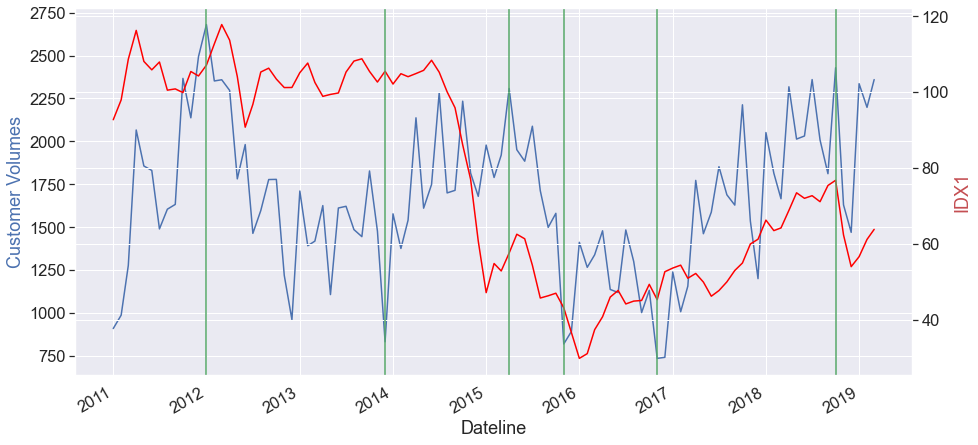

In [8]:
Series1 = "Customer Volumes"
Series2 = "IDX1"
DoLinePlot_wVLines()

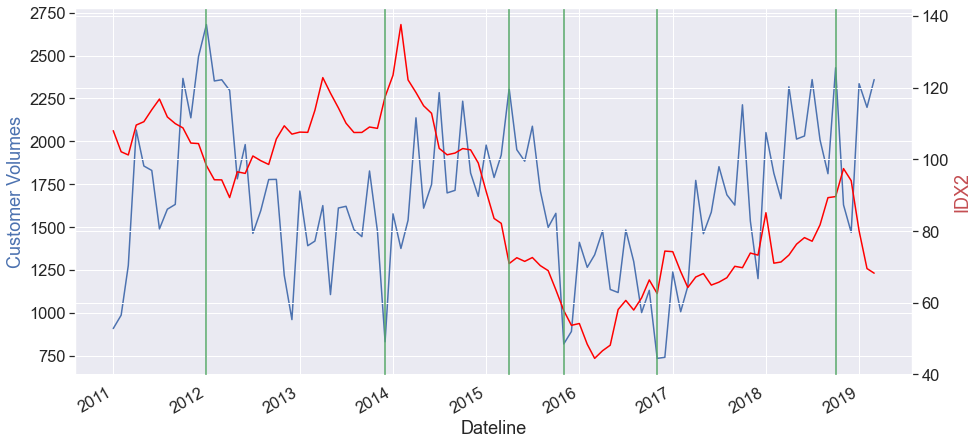

In [9]:
Series1 = "Customer Volumes"
Series2 = "IDX2"
DoLinePlot_wVLines()

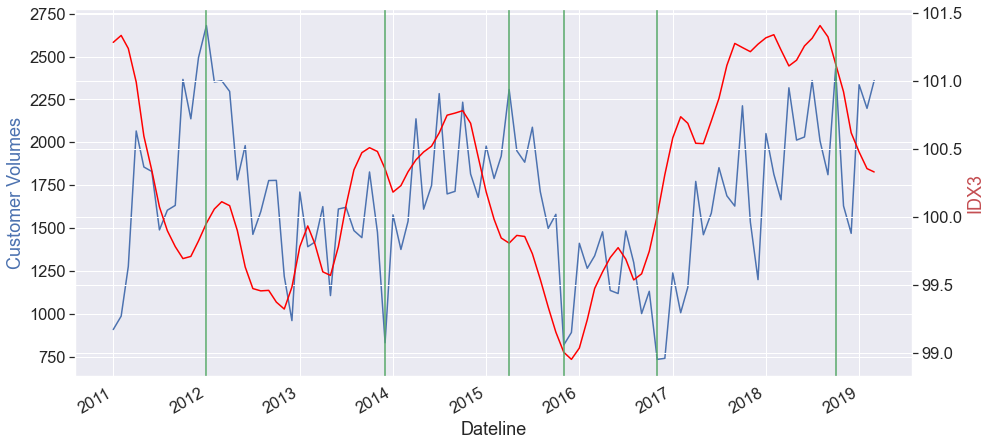

In [10]:
Series1 = "Customer Volumes"
Series2 = "IDX3"
DoLinePlot_wVLines()

### Split into Train and Test

In [11]:
n_obs=18

df_train, df_test = df[0:-n_obs], df[-n_obs:]
print(df_train.shape, df_test.shape)

(81, 4) (18, 4)


### ADF Stationary Test

In [12]:
### 1. ADF statistic less than several critical values
### 2. P-Value less than 0.05

In [13]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [14]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1179
 No. Lags Chosen       = 12
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0253. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1394
 No. Lags Chosen       = 1
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.6991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

###  First order difference transform

Clearly, our series are non stationary, so let's go ahead and use the first order difference method and check if they are stationary

In [15]:
df_differenced = df_train.diff().dropna()

In [16]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9075
 No. Lags Chosen       = 11
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0445. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1381
 No. Lags Chosen       = 0
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

It looks like the first order difference worked to make our time series stationary. Let's move to seeing which indicators are leading using granger's causality test

### Granger Causality test

We want to identify if any of the indices are leading indicators. A quick visual plot showed that Index 3 has peaks and troughs that clearly lead the peaks and troughs in the customer volume. 

Let's dig in deeper and do an actual statistical test to see which of the indices can be used to predict customer volumes. 

Granger's Causality Test is used to confirm or deny if one time series can be used to predict another time series. Any time series that has a p-value less than the level of significance satisty the properties of causality - the feature must be be leading the target variable, the magnitude of change in the feature corresponds to a proportional level of change in the target, etc. 

In our case we want to see if indices 1, 2 and 3 can be used to predict customer volume.

Granger's causality test requires:

* the input time series to be stationary

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=13
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)  

,Customer Volumes_x,IDX1_x,IDX2_x,IDX3_x
Customer Volumes_y,1.0000,0.0011,0.1937,0.0113
IDX1_y,0.1348,1.0000,0.0334,0.0004
IDX2_y,0.6241,0.0010,1.0000,0.0003
IDX3_y,0.0004,0.0820,0.0001,1.0000


From the results of the grangers causality test, we can clearly see that the idx1 and idx3 can be used as leading indicators to predict customer volumes for a maximum lag of 6 months because their p-values are less than the level of significance = 0.05 . 

### Johansen's Cointegration Test

To apply VAR model, we want to examine if the target value (customer volume) can be achieved as a linear combination of lagged features (IDX1, IDX2, and IDX3). VAR model assumes co-integration among the features so it makes sense to check if the features are co-integrated using a Johansen's co-integration test.

Here, we perform co-integration test on the first order difference of all the time series. If two or more time series are co-integrated, their nth order difference are also co-integrated. Johansen's co-integration test can only be performed on stationary time series. Hence, we use the first order difference to make all the time series stationary.

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Customer Volumes ::  73.95     > 40.1749   =>   True
IDX1   ::  35.54     > 24.2761   =>   True
IDX2   ::  19.3      > 12.3212   =>   True
IDX3   ::  5.95      > 4.1296    =>   True


### Select the Lag Order (P) of VAR model

We need to determine the lag order of the leading indicators to apply the VAR model. We are selecting the lag order that corresponds to the minimum AIC score.


In [19]:
df_differenced = df_differenced[['Customer Volumes','IDX1','IDX3']]

In [20]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  10.386755538932084
Lag Order = 2
AIC :  9.800789089846907
Lag Order = 3
AIC :  9.65092973835701
Lag Order = 4
AIC :  9.64186623744201
Lag Order = 5
AIC :  9.774936108989381
Lag Order = 6
AIC :  9.589716315032712
Lag Order = 7
AIC :  9.696625437706592
Lag Order = 8
AIC :  9.705071315167974
Lag Order = 9
AIC :  9.703460609646799
Lag Order = 10
AIC :  9.763126463698883
Lag Order = 11
AIC :  9.562890270783079
Lag Order = 12
AIC :  9.492783436649239
Lag Order = 13
AIC :  9.377676427846547


In [21]:
x = model.select_order(maxlags=13)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.08,11.17,6.457e+04,11.11
1,10.24,10.63,2.792e+04,10.39
2,9.513,10.20*,1.356e+04,9.786*
3,9.446,10.43,1.274e+04*,9.837
4,9.441,10.72,1.279e+04,9.949
5,9.631,11.21,1.567e+04,10.26
6,9.707,11.58,1.724e+04,10.45
7,9.629,11.80,1.639e+04,10.49
8,9.541,12.01,1.560e+04,10.52
9,9.489,12.25,1.556e+04,10.58


### 1. Var Model

### Train the VAR Model of Selected Order(p)

In [22]:
model_fitted = model.fit(13)
# model_fitted.summary()

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ': \t \t \t', round(val, 2))


Customer Volumes : 	 	 	 1.97
IDX1 : 	 	 	 2.18
IDX3 : 	 	 	 1.87


The Durbin Watson Statistic between 0-2 represent positive autocorrelation in the residuals and 2-4 represent negative autocorrelation. When modeling, we aim the statistic to be between 1.5-2.5 as a rule of thumb. The values of our statistic for all three residuals are between 1.5-2.5, so we assume that our modeling approach is sound. 

### Forecast VAR model using statsmodels

In [24]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

13


array([[-2.98000000e+02,  1.66666667e-01,  4.51100000e-02],
       [ 1.30000000e+02,  4.25000000e+00,  1.65820000e-01],
       [-3.97000000e+02, -4.03333333e+00,  2.61770000e-01],
       [ 6.00000000e+00,  7.36000000e+00,  3.03000000e-01],
       [ 4.98000000e+02,  9.70000000e-01,  2.70400000e-01],
       [-2.32000000e+02,  7.63333333e-01,  1.55400000e-01],
       [ 1.49000000e+02, -3.45000000e+00, -4.83000000e-02],
       [ 6.17000000e+02,  1.26000000e+00, -1.46900000e-01],
       [-3.11000000e+02, -2.27000000e+00, -2.60000000e-03],
       [ 1.26000000e+02, -3.72666667e+00,  1.66600000e-01],
       [ 2.65000000e+02,  1.49000000e+00,  1.66400000e-01],
       [-1.64000000e+02,  2.28666667e+00,  2.42900000e-01],
       [-6.00000000e+01,  3.00666667e+00,  1.61800000e-01]])

In [25]:
df_selected = df[['Customer Volumes','IDX1','IDX3']]

In [26]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=n_obs)
df_forecast = pd.DataFrame(fc, index=df_selected.index[-n_obs:], columns=df_selected.columns + '_pred')
df_forecast

,Customer Volumes_pred,IDX1_pred,IDX3_pred
Month,,,
2017-10-01,384.805607,-11.382315,-0.008836
2017-11-01,-437.786837,-10.186532,-0.216428
2017-12-01,-27.597831,-5.219113,-0.292797
2018-01-01,483.310200,-4.218701,-0.258670
2018-02-01,-327.594337,-3.199339,-0.094856
2018-03-01,208.650708,-0.428344,-0.046078
2018-04-01,269.036879,-0.369242,0.017514
2018-05-01,-572.222375,2.555019,0.078183
2018-06-01,129.335641,-4.344196,0.057294


In [27]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_pred'].cumsum()
    return df_fc

In [28]:
df_results = invert_transformation(df_train[['Customer Volumes','IDX1','IDX3']], df_forecast)

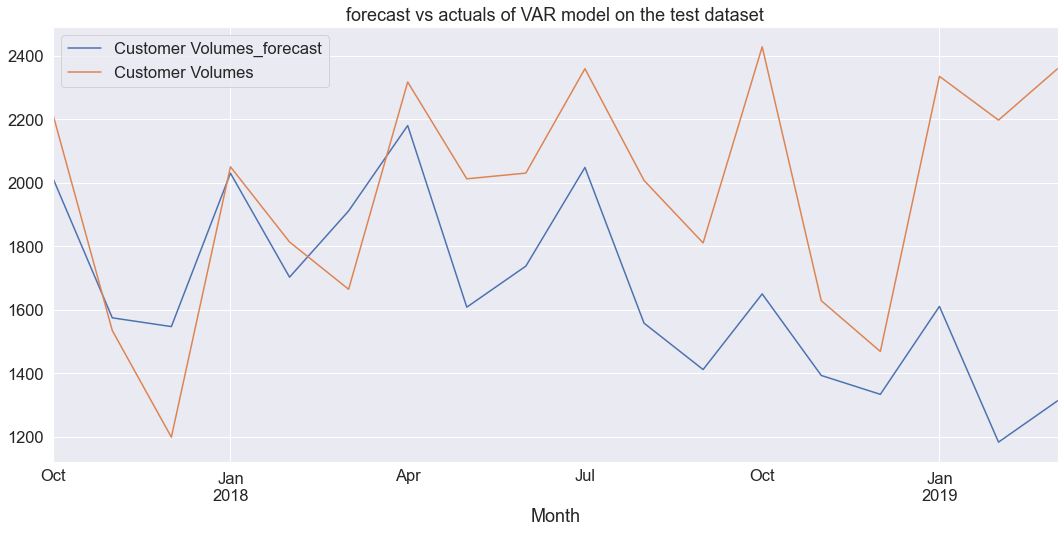

In [29]:
df_results['Customer Volumes'+'_forecast'].plot(legend=True)
df_test['Customer Volumes'][-n_obs:].plot(legend=True)
ax.set_title('Customer Volumes' + ": Forecast vs Actuals")
plt.title("forecast vs actuals of VAR model on the test dataset")
plt.show()

### Evaluate

In [30]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): 
        return str(val).ljust(length)
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(df_results['Customer Volumes_forecast'].values, df_test['Customer Volumes'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.1877
me     :  -312.5384
mae    :  383.1192
mpe    :  -0.1361
rmse   :  488.3598
corr   :  0.2968
minmax :  0.183


### next 18 month forecast

In [31]:
df_difference_all = df.diff().dropna()

In [32]:
df_difference_all = df_difference_all[['Customer Volumes','IDX1','IDX3']]

In [33]:
# selected lag order=3 from above
model_fitted = model.fit(13)

In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_difference_all.values[-lag_order:]
forecast_input

13


array([[-1.49000000e+02,  7.06666667e-01, -1.12100000e-01],
       [ 6.53000000e+02,  4.62666667e+00, -1.17900000e-01],
       [-3.05000000e+02,  4.63666667e+00,  4.23000000e-02],
       [ 1.80000000e+01, -1.45333333e+00,  1.04800000e-01],
       [ 3.29000000e+02,  6.90000000e-01,  5.65000000e-02],
       [-3.52000000e+02, -1.58333333e+00,  9.38000000e-02],
       [-1.97000000e+02,  4.28000000e+00, -8.32000000e-02],
       [ 6.18000000e+02,  1.36333333e+00, -1.98400000e-01],
       [-8.00000000e+02, -1.44100000e+01, -2.06000000e-01],
       [-1.60000000e+02, -8.35666667e+00, -3.02000000e-01],
       [ 8.67000000e+02,  2.62333333e+00, -1.40900000e-01],
       [-1.38000000e+02,  4.55000000e+00, -1.22800000e-01],
       [ 1.62000000e+02,  2.65333333e+00, -2.47000000e-02]])

In [35]:
# Forecast
indexes=indexes.set_index('Month')
fc = model_fitted.forecast(y=forecast_input, steps=18)
df_forecast_18 = pd.DataFrame(fc, index=indexes.index[-18:], columns=df_difference_all.columns + '_pred')
df_forecast_18

,Customer Volumes_pred,IDX1_pred,IDX3_pred
Month,,,
2019-04-01,149.018231,-9.142526,0.217354
2019-05-01,-1045.894260,8.629520,0.245608
2019-06-01,598.336179,-8.870957,0.182720
2019-07-01,56.029884,-4.787258,0.174137
2019-08-01,-112.112430,-3.100225,-0.132450
2019-09-01,7.629764,-12.577083,-0.369512
2019-10-01,-240.821180,0.201288,-0.414249
2019-11-01,-48.084518,0.749971,-0.233831
2019-12-01,-36.455281,-1.954341,0.097653


In [36]:
df_results_18 = invert_transformation(df[['Customer Volumes','IDX1','IDX3']], df_forecast_18)

In [37]:
df_results_18[['Customer Volumes_forecast']]

,Customer Volumes_forecast
Month,
2019-04-01,2509.018231
2019-05-01,1463.123971
2019-06-01,2061.460150
2019-07-01,2117.490033
2019-08-01,2005.377604
2019-09-01,2013.007368
2019-10-01,1772.186188
2019-11-01,1724.101671
2019-12-01,1687.646390


### 2. fbprophet

In [38]:
import itertools
from prophet import Prophet

### prepare data

In [78]:
# prepare data for fbprophet model
df = df.reset_index()
df.columns = ['ds', 'y', 'IDX1', 'IDX2', 'IDX3']

In [40]:
df_fb = df.copy()
df_fb.head()

,ds,y,IDX1,IDX2,IDX3
0,2011-01-01,908.0,92.690595,108.008014,101.2842
1,2011-02-01,986.0,97.914192,102.123691,101.3352
2,2011-03-01,1276.0,108.645217,101.238374,101.2392
3,2011-04-01,2066.0,116.243167,109.568848,100.9917
4,2011-05-01,1856.0,108.068513,110.511852,100.5940


In [41]:
df.head()
df.columns =['ds', 'y', 'IDX1', 'IDX2', 'IDX3']
future_idx1 = indexes['IDX1'].reset_index(drop=True)
future_idx3 =indexes['IDX3'].reset_index(drop=True)

df=df.dropna(how='any')
df=df.reset_index(drop=True)
df.tail()

,ds,y,IDX1,IDX2,IDX3
94,2018-11-01,1629.0,62.316667,97.431685,100.9204
95,2018-12-01,1469.0,53.960000,94.062920,100.6184
96,2019-01-01,2336.0,56.583333,80.055366,100.4775
97,2019-02-01,2198.0,61.133333,69.545042,100.3547
98,2019-03-01,2360.0,63.786667,68.259255,100.3300


### hyperparameter tuning for prophet

In [42]:
# choosing cutoffs to mark the macro inflection points
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
cutoffs = pd.to_datetime(['2013-11-01', '2016-11-01'])


param_grid = {  
    'changepoint_prior_scale': [ .5, .6, .8, .9, 1.0],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, growth='linear',
            seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            weekly_seasonality=False,
            ).add_regressor('IDX1').add_regressor('IDX3').fit(df)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5eb250>



Initial log joint probability = -125.634
Iteration  1. Log joint probability =    44.2129. Improved by 169.847.
Iteration  2. Log joint probability =    89.2551. Improved by 45.0422.
Iteration  3. Log joint probability =    115.378. Improved by 26.1225.
Iteration  4. Log joint probability =    121.405. Improved by 6.02737.
Iteration  5. Log joint probability =    125.515. Improved by 4.11047.
Iteration  6. Log joint probability =    127.599. Improved by 2.08351.
Iteration  7. Log joint probability =    130.968. Improved by 3.36934.
Iteration  8. Log joint probability =    139.144. Improved by 8.17539.
Iteration  9. Log joint probability =     139.55. Improved by 0.406203.
Iteration 10. Log joint probability =    140.672. Improved by 1.12257.
Iteration 11. Log joint probability =    141.399. Improved by 0.726845.
Iteration 12. Log joint probability =    141.425. Improved by 0.0253647.
Iteration 13. Log joint probability =    141.467. Improved by 0.0425376.
Iteration 14. Log joint proba


Initial log joint probability = -65.5031
Iteration  1. Log joint probability =    13.7058. Improved by 79.2089.

Initial log joint probability = -101.449
Iteration  2. Log joint probability =    41.5511. Improved by 27.8453.
Iteration  1. Log joint probability =    40.0533. Improved by 141.502.
Iteration  3. Log joint probability =    58.1543. Improved by 16.6031.
Iteration  4. Log joint probability =    58.1569. Improved by 0.00260111.
Iteration  2. Log joint probability =    88.0427. Improved by 47.9894.
Iteration  5. Log joint probability =    58.1631. Improved by 0.00627613.
Iteration  3. Log joint probability =    101.611. Improved by 13.568.
Iteration  6. Log joint probability =    58.1675. Improved by 0.00441388.
Iteration  7. Log joint probability =    67.3368. Improved by 9.16928.
Iteration  4. Log joint probability =    101.631. Improved by 0.0202087.
Iteration  8. Log joint probability =    68.6788. Improved by 1.34193.
Iteration  5. Log joint probability =    101.679. Impr

Iteration 87. Log joint probability =    92.9934. Improved by 0.000170241.
Iteration 53. Log joint probability =    110.174. Improved by 0.455241.
Iteration 88. Log joint probability =    92.9936. Improved by 0.000168441.
Iteration 89. Log joint probability =    92.9938. Improved by 0.000206252.
Iteration 54. Log joint probability =    110.242. Improved by 0.067852.
Iteration 90. Log joint probability =    92.9939. Improved by 8.87526e-05.
Iteration 55. Log joint probability =      110.3. Improved by 0.0582614.
Iteration 91. Log joint probability =    92.9939. Improved by 3.33481e-05.
Iteration 92. Log joint probability =    92.9939. Improved by 4.25614e-05.
Iteration 56. Log joint probability =    110.339. Improved by 0.0391379.
Iteration 93. Log joint probability =    92.9941. Improved by 0.000126158.
Iteration 94. Log joint probability =    92.9941. Improved by 6.52977e-05.
Iteration 57. Log joint probability =    110.361. Improved by 0.0218003.
Iteration 95. Log joint probability =

Iteration 123. Log joint probability =    141.676. Improved by 0.0148808.
Iteration 124. Log joint probability =    141.686. Improved by 0.0106292.
Iteration 125. Log joint probability =    141.691. Improved by 0.00486087.
Iteration 126. Log joint probability =    141.698. Improved by 0.00647236.
Iteration 127. Log joint probability =    141.717. Improved by 0.0193518.
Iteration 128. Log joint probability =    141.815. Improved by 0.0979693.
Iteration 129. Log joint probability =    141.821. Improved by 0.00591285.
Iteration 130. Log joint probability =    141.899. Improved by 0.0784741.
Iteration 131. Log joint probability =    141.925. Improved by 0.0258845.
Iteration 132. Log joint probability =    141.931. Improved by 0.0057613.
Iteration 133. Log joint probability =    142.004. Improved by 0.0732012.
Iteration 134. Log joint probability =    142.007. Improved by 0.00275095.
Iteration 135. Log joint probability =    142.013. Improved by 0.00639453.
Iteration 136. Log joint probabil

Iteration 241. Log joint probability =    144.193. Improved by 3.35427e-08.
Iteration 242. Log joint probability =    144.193. Improved by 4.70487e-08.
Iteration 243. Log joint probability =    144.193. Improved by 7.95723e-08.
Iteration 244. Log joint probability =    144.193. Improved by 3.50715e-08.
Iteration 245. Log joint probability =    144.193. Improved by 3.86139e-08.
Iteration 246. Log joint probability =    144.193. Improved by 4.79982e-08.
Iteration 247. Log joint probability =    144.193. Improved by 6.79074e-09.


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21d4723d0>



Initial log joint probability = -157.823
Iteration  1. Log joint probability =    42.2492. Improved by 200.072.
Iteration  2. Log joint probability =    99.6308. Improved by 57.3816.
Iteration  3. Log joint probability =    102.226. Improved by 2.59507.
Iteration  4. Log joint probability =    123.472. Improved by 21.2461.
Iteration  5. Log joint probability =     123.48. Improved by 0.00783512.
Iteration  6. Log joint probability =    123.491. Improved by 0.0112842.
Iteration  7. Log joint probability =    123.532. Improved by 0.0404076.
Iteration  8. Log joint probability =    123.578. Improved by 0.0466773.
Iteration  9. Log joint probability =    123.624. Improved by 0.0455535.
Iteration 10. Log joint probability =    136.257. Improved by 12.6332.
Iteration 11. Log joint probability =     136.47. Improved by 0.213351.
Iteration 12. Log joint probability =    136.579. Improved by 0.108286.
Iteration 13. Log joint probability =    136.794. Improved by 0.214866.
Iteration 14. Log joi


Initial log joint probability = -97.6918
Iteration  1. Log joint probability =    3.68631. Improved by 101.378.

Initial log joint probability = -133.638
Iteration  2. Log joint probability =    17.9436. Improved by 14.2573.
Iteration  1. Log joint probability =  0.0627741. Improved by 133.7.
Iteration  3. Log joint probability =    17.9473. Improved by 0.00375833.
Iteration  4. Log joint probability =    17.9537. Improved by 0.0063502.
Iteration  2. Log joint probability =     69.514. Improved by 69.4513.
Iteration  5. Log joint probability =    27.8106. Improved by 9.85693.
Iteration  3. Log joint probability =    85.3287. Improved by 15.8146.
Iteration  6. Log joint probability =    27.8366. Improved by 0.0259799.
Iteration  7. Log joint probability =    27.8549. Improved by 0.0182674.
Iteration  4. Log joint probability =    85.3308. Improved by 0.00215455.
Iteration  8. Log joint probability =     27.869. Improved by 0.014155.
Iteration  5. Log joint probability =    85.3319. Imp

Iteration 84. Log joint probability =    46.1675. Improved by 0.35097.
Iteration 54. Log joint probability =    119.842. Improved by 0.0439881.
Iteration 85. Log joint probability =    46.3557. Improved by 0.188247.
Iteration 55. Log joint probability =    119.922. Improved by 0.0805917.
Iteration 86. Log joint probability =    46.4339. Improved by 0.0781447.
Iteration 87. Log joint probability =    46.4543. Improved by 0.0203734.
Iteration 56. Log joint probability =    119.953. Improved by 0.0307185.
Iteration 88. Log joint probability =    46.5061. Improved by 0.0518794.
Iteration 57. Log joint probability =    120.068. Improved by 0.115326.
Iteration 89. Log joint probability =    46.5528. Improved by 0.0467121.
Iteration 90. Log joint probability =    46.5782. Improved by 0.02535.
Iteration 58. Log joint probability =     120.09. Improved by 0.0216788.
Iteration 91. Log joint probability =    46.6515. Improved by 0.0733177.
Iteration 59. Log joint probability =    120.096. Improve

Iteration 169. Log joint probability =    89.7104. Improved by 0.990394.
Iteration 170. Log joint probability =    89.7719. Improved by 0.0615147.
Iteration 111. Log joint probability =    144.518. Improved by 0.0810776.
Iteration 171. Log joint probability =    90.4094. Improved by 0.637507.
Iteration 112. Log joint probability =    144.569. Improved by 0.0510932.
Iteration 172. Log joint probability =    90.7163. Improved by 0.306904.
Iteration 173. Log joint probability =    90.9516. Improved by 0.235273.
Iteration 113. Log joint probability =    144.591. Improved by 0.0217073.
Iteration 174. Log joint probability =    90.9602. Improved by 0.00866606.
Iteration 114. Log joint probability =    144.597. Improved by 0.0060547.
Iteration 175. Log joint probability =    91.0645. Improved by 0.104267.
Iteration 176. Log joint probability =    91.1138. Improved by 0.0493196.
Iteration 115. Log joint probability =    144.612. Improved by 0.0153457.
Iteration 177. Log joint probability =    

Iteration 236. Log joint probability =    94.1446. Improved by 0.466618.
Iteration 155. Log joint probability =    145.489. Improved by 2.06119e-05.
Iteration 237. Log joint probability =    94.8128. Improved by 0.668167.
Iteration 238. Log joint probability =    94.8303. Improved by 0.017553.
Iteration 156. Log joint probability =    145.489. Improved by 0.000332133.
Iteration 239. Log joint probability =    94.8347. Improved by 0.00440792.
Iteration 157. Log joint probability =     145.49. Improved by 0.000102663.
Iteration 240. Log joint probability =    95.0036. Improved by 0.168882.
Iteration 241. Log joint probability =    95.0048. Improved by 0.00119195.
Iteration 158. Log joint probability =     145.49. Improved by 3.69711e-05.
Iteration 242. Log joint probability =    95.0064. Improved by 0.00158375.
Iteration 159. Log joint probability =     145.49. Improved by 8.69405e-05.
Iteration 243. Log joint probability =    95.0093. Improved by 0.00286669.
Iteration 244. Log joint pro

Iteration 83. Log joint probability =    184.007. Improved by 0.894813.
Iteration 84. Log joint probability =    184.509. Improved by 0.501836.
Iteration 85. Log joint probability =    184.712. Improved by 0.202666.
Iteration 86. Log joint probability =    184.942. Improved by 0.230657.
Iteration 87. Log joint probability =    185.023. Improved by 0.0810738.
Iteration 88. Log joint probability =    185.088. Improved by 0.0647473.
Iteration 89. Log joint probability =    185.206. Improved by 0.118048.
Iteration 90. Log joint probability =     185.23. Improved by 0.0241509.
Iteration 91. Log joint probability =    185.265. Improved by 0.034595.
Iteration 92. Log joint probability =    185.289. Improved by 0.023785.
Iteration 93. Log joint probability =    185.323. Improved by 0.0346455.
Iteration 94. Log joint probability =    185.346. Improved by 0.0230944.
Iteration 95. Log joint probability =    185.381. Improved by 0.0350413.
Iteration 96. Log joint probability =    185.417. Improved

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c57e350>



Initial log joint probability = -171.685
Iteration  1. Log joint probability =    41.5225. Improved by 213.208.
Iteration  2. Log joint probability =    98.3019. Improved by 56.7795.
Iteration  3. Log joint probability =     122.72. Improved by 24.4185.
Iteration  4. Log joint probability =    147.031. Improved by 24.3106.
Iteration  5. Log joint probability =    147.045. Improved by 0.0143526.
Iteration  6. Log joint probability =    147.066. Improved by 0.0201555.
Iteration  7. Log joint probability =     147.08. Improved by 0.0140919.
Iteration  8. Log joint probability =    147.098. Improved by 0.0185372.
Iteration  9. Log joint probability =    147.105. Improved by 0.00726893.
Iteration 10. Log joint probability =     147.14. Improved by 0.0349361.
Iteration 11. Log joint probability =    147.339. Improved by 0.198584.
Iteration 12. Log joint probability =    148.419. Improved by 1.07985.
Iteration 13. Log joint probability =    148.598. Improved by 0.178689.
Iteration 14. Log jo

Iteration 206. Log joint probability =    188.702. Improved by 0.00606897.
Iteration 207. Log joint probability =    188.717. Improved by 0.015693.
Iteration 208. Log joint probability =    188.728. Improved by 0.0108371.
Iteration 209. Log joint probability =    188.747. Improved by 0.0190464.
Iteration 210. Log joint probability =    188.775. Improved by 0.0277981.
Iteration 211. Log joint probability =    188.847. Improved by 0.0716373.
Iteration 212. Log joint probability =    188.847. Improved by 0.000459209.
Iteration 213. Log joint probability =    188.877. Improved by 0.0296862.
Iteration 214. Log joint probability =    188.877. Improved by 4.40733e-05.
Iteration 215. Log joint probability =    189.021. Improved by 0.144063.
Iteration 216. Log joint probability =    189.027. Improved by 0.00605742.
Iteration 217. Log joint probability =    189.028. Improved by 0.000787899.
Iteration 218. Log joint probability =    189.158. Improved by 0.130607.
Iteration 219. Log joint probabil

Iteration 42. Log joint probability =    56.5698. Improved by 11.9253.
Iteration 43. Log joint probability =    56.5777. Improved by 0.00794961.
Iteration 28. Log joint probability =    89.0088. Improved by 0.0381897.
Iteration 44. Log joint probability =    56.6096. Improved by 0.0318958.
Iteration 29. Log joint probability =    89.1235. Improved by 0.114699.
Iteration 45. Log joint probability =    56.6482. Improved by 0.0385902.
Iteration 30. Log joint probability =     89.174. Improved by 0.0505377.
Iteration 46. Log joint probability =    56.6715. Improved by 0.0232316.
Iteration 47. Log joint probability =    56.6797. Improved by 0.00826243.
Iteration 31. Log joint probability =    89.2594. Improved by 0.0853968.
Iteration 48. Log joint probability =    56.7831. Improved by 0.103376.
Iteration 32. Log joint probability =    89.2845. Improved by 0.0250111.
Iteration 49. Log joint probability =    56.7895. Improved by 0.0063962.
Iteration 50. Log joint probability =    56.7959. Imp

Iteration 124. Log joint probability =    75.7051. Improved by 1.22654.
Iteration 84. Log joint probability =    98.0513. Improved by 1.10499.
Iteration 125. Log joint probability =    75.8519. Improved by 0.146762.
Iteration 126. Log joint probability =    76.0567. Improved by 0.204866.
Iteration 85. Log joint probability =    98.4293. Improved by 0.37797.
Iteration 127. Log joint probability =    76.3595. Improved by 0.302796.
Iteration 86. Log joint probability =    98.8936. Improved by 0.464388.
Iteration 128. Log joint probability =      76.52. Improved by 0.160484.
Iteration 129. Log joint probability =     76.687. Improved by 0.166932.
Iteration 87. Log joint probability =     99.053. Improved by 0.159347.
Iteration 130. Log joint probability =    78.2963. Improved by 1.60932.
Iteration 88. Log joint probability =      101.6. Improved by 2.54717.
Iteration 131. Log joint probability =    78.8127. Improved by 0.516417.
Iteration 132. Log joint probability =    79.1426. Improved b

Iteration 210. Log joint probability =    93.5233. Improved by 0.0753731.
Iteration 211. Log joint probability =    93.5238. Improved by 0.000429257.
Iteration 141. Log joint probability =    142.569. Improved by 0.0340178.
Iteration 212. Log joint probability =    93.5279. Improved by 0.00413847.
Iteration 142. Log joint probability =    142.584. Improved by 0.0146078.
Iteration 213. Log joint probability =    93.5425. Improved by 0.0145995.
Iteration 214. Log joint probability =    93.5469. Improved by 0.00436319.
Iteration 143. Log joint probability =    142.635. Improved by 0.0515886.
Iteration 215. Log joint probability =    93.5871. Improved by 0.0402796.
Iteration 216. Log joint probability =    93.7528. Improved by 0.165678.
Iteration 144. Log joint probability =     142.67. Improved by 0.0347958.
Iteration 217. Log joint probability =    93.9555. Improved by 0.20268.
Iteration 145. Log joint probability =    142.759. Improved by 0.0886483.
Iteration 218. Log joint probability 

Iteration 279. Log joint probability =    95.2662. Improved by 5.8699e-07.
Iteration 184. Log joint probability =    144.638. Improved by 0.0207157.
Iteration 280. Log joint probability =    95.2662. Improved by 4.31207e-07.
Iteration 185. Log joint probability =    144.639. Improved by 0.00116802.
Iteration 281. Log joint probability =    95.2662. Improved by 7.52474e-07.
Iteration 282. Log joint probability =    95.2662. Improved by 2.5133e-07.
Iteration 186. Log joint probability =    144.669. Improved by 0.0300232.
Iteration 283. Log joint probability =    95.2662. Improved by 4.92129e-07.
Iteration 187. Log joint probability =    144.676. Improved by 0.00675683.
Iteration 284. Log joint probability =    95.2662. Improved by 1.17352e-07.
Iteration 285. Log joint probability =    95.2662. Improved by 6.00626e-08.
Iteration 188. Log joint probability =    144.685. Improved by 0.00926246.
Iteration 286. Log joint probability =    95.2662. Improved by 2.13973e-07.
Iteration 189. Log jo

ation 70. Log joint probability =     160.29. Improved by 0.0544457.
Iteration 71. Log joint probability =      160.4. Improved by 0.110932.
Iteration 72. Log joint probability =    160.484. Improved by 0.0838103.
Iteration 73. Log joint probability =    160.594. Improved by 0.109613.
Iteration 74. Log joint probability =    160.801. Improved by 0.207312.
Iteration 75. Log joint probability =    160.914. Improved by 0.113025.
Iteration 76. Log joint probability =    160.918. Improved by 0.0036565.
Iteration 77. Log joint probability =    160.932. Improved by 0.0142743.
Iteration 78. Log joint probability =    161.021. Improved by 0.0888358.
Iteration 79. Log joint probability =    161.036. Improved by 0.0150933.
Iteration 80. Log joint probability =    161.063. Improved by 0.0270414.
Iteration 81. Log joint probability =     161.14. Improved by 0.0769403.
Iteration 82. Log joint probability =    161.191. Improved by 0.0510643.
Iteration 83. Log joint probability =    161.192. Improved 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21d463210>



Initial log joint probability = -130.192
Iteration  1. Log joint probability =      44.17. Improved by 174.362.
Iteration  2. Log joint probability =     89.079. Improved by 44.909.
Iteration  3. Log joint probability =    113.531. Improved by 24.4519.
Iteration  4. Log joint probability =    118.224. Improved by 4.69332.
Iteration  5. Log joint probability =    120.323. Improved by 2.09902.
Iteration  6. Log joint probability =    122.306. Improved by 1.98288.
Iteration  7. Log joint probability =    122.695. Improved by 0.388602.
Iteration  8. Log joint probability =    124.971. Improved by 2.27648.
Iteration  9. Log joint probability =     125.06. Improved by 0.0886106.
Iteration 10. Log joint probability =    129.258. Improved by 4.19785.
Iteration 11. Log joint probability =     131.51. Improved by 2.2526.
Iteration 12. Log joint probability =    133.396. Improved by 1.88572.
Iteration 13. Log joint probability =    133.594. Improved by 0.197435.
Iteration 14. Log joint probabili


Initial log joint probability = -70.0611

Initial log joint probability = -106.007
Iteration  1. Log joint probability =     13.706. Improved by 83.7671.
Iteration  2. Log joint probability =    41.5573. Improved by 27.8513.
Iteration  1. Log joint probability =    40.0587. Improved by 146.066.
Iteration  3. Log joint probability =    58.1712. Improved by 16.6139.
Iteration  2. Log joint probability =     87.984. Improved by 47.9252.
Iteration  4. Log joint probability =    58.1741. Improved by 0.00295465.
Iteration  5. Log joint probability =    58.1797. Improved by 0.00557641.
Iteration  3. Log joint probability =    101.508. Improved by 13.5244.
Iteration  6. Log joint probability =    58.1823. Improved by 0.00262804.
Iteration  4. Log joint probability =    101.585. Improved by 0.0763615.
Iteration  7. Log joint probability =    58.1937. Improved by 0.0113275.
Iteration  8. Log joint probability =    58.2123. Improved by 0.0186658.
Iteration  5. Log joint probability =    101.587.

Iteration 84. Log joint probability =    88.7775. Improved by 0.00232086.
Iteration 85. Log joint probability =    88.7863. Improved by 0.00875896.
Iteration 55. Log joint probability =     104.42. Improved by 0.203094.
Iteration 86. Log joint probability =    88.7905. Improved by 0.0042146.
Iteration 87. Log joint probability =    88.8082. Improved by 0.0177638.
Iteration 56. Log joint probability =    104.441. Improved by 0.0216958.
Iteration 88. Log joint probability =    88.8162. Improved by 0.00792071.
Iteration 57. Log joint probability =    104.513. Improved by 0.0713271.
Iteration 89. Log joint probability =    88.8518. Improved by 0.0356274.
Iteration 90. Log joint probability =    88.8567. Improved by 0.00490561.
Iteration 58. Log joint probability =    104.545. Improved by 0.0324965.
Iteration 91. Log joint probability =    88.8794. Improved by 0.0226952.
Iteration 59. Log joint probability =    104.562. Improved by 0.016366.
Iteration 92. Log joint probability =    88.8818.

Iteration 171. Log joint probability =    94.6233. Improved by 0.00197603.
Iteration 110. Log joint probability =    143.984. Improved by 0.00980111.
Iteration 172. Log joint probability =    94.6238. Improved by 0.000476002.
Iteration 111. Log joint probability =    144.114. Improved by 0.129627.
Iteration 173. Log joint probability =    94.6247. Improved by 0.000880195.
Iteration 174. Log joint probability =    94.6251. Improved by 0.000487601.
Iteration 112. Log joint probability =    144.137. Improved by 0.0232404.
Iteration 175. Log joint probability =    94.6252. Improved by 3.48915e-05.
Iteration 176. Log joint probability =    94.6253. Improved by 9.59836e-05.
Iteration 113. Log joint probability =    144.149. Improved by 0.0115091.
Iteration 177. Log joint probability =    94.6253. Improved by 7.02778e-05.
Iteration 114. Log joint probability =    144.158. Improved by 0.00890155.
Iteration 178. Log joint probability =    94.6255. Improved by 0.000183704.
Iteration 179. Log joi

Iteration 169. Log joint probability =    147.967. Improved by 0.00014529.
Iteration 170. Log joint probability =     147.97. Improved by 0.00214236.
Iteration 171. Log joint probability =    147.971. Improved by 0.00142419.
Iteration 172. Log joint probability =    147.971. Improved by 0.000157652.
Iteration 173. Log joint probability =    147.972. Improved by 0.000781527.
Iteration 174. Log joint probability =    147.972. Improved by 0.000152123.
Iteration 175. Log joint probability =    147.973. Improved by 0.000522244.
Iteration 176. Log joint probability =    147.973. Improved by 9.09308e-05.
Iteration 177. Log joint probability =    147.973. Improved by 0.00012938.
Iteration 178. Log joint probability =    147.973. Improved by 9.24185e-05.
Iteration 179. Log joint probability =    147.973. Improved by 6.4964e-05.
Iteration 180. Log joint probability =    147.973. Improved by 9.88764e-05.
Iteration 181. Log joint probability =    147.973. Improved by 5.87261e-05.
Iteration 182. Lo

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5a8650>



Initial log joint probability = -162.381
Iteration  1. Log joint probability =    42.2565. Improved by 204.637.
Iteration  2. Log joint probability =     103.51. Improved by 61.254.
Iteration  3. Log joint probability =    125.903. Improved by 22.3927.
Iteration  4. Log joint probability =    129.443. Improved by 3.54016.
Iteration  5. Log joint probability =    129.448. Improved by 0.00433369.
Iteration  6. Log joint probability =     129.46. Improved by 0.012492.
Iteration  7. Log joint probability =    129.464. Improved by 0.00394426.
Iteration  8. Log joint probability =    129.477. Improved by 0.012901.
Iteration  9. Log joint probability =    129.484. Improved by 0.00687862.
Iteration 10. Log joint probability =    129.496. Improved by 0.0126097.
Iteration 11. Log joint probability =    129.504. Improved by 0.00796615.
Iteration 12. Log joint probability =    129.514. Improved by 0.00957535.
Iteration 13. Log joint probability =    129.549. Improved by 0.034697.
Iteration 14. Lo

Iteration 138. Log joint probability =    183.402. Improved by 0.293475.
Iteration 139. Log joint probability =    183.857. Improved by 0.455248.
Iteration 140. Log joint probability =    184.425. Improved by 0.567893.
Iteration 141. Log joint probability =    185.365. Improved by 0.94024.
Iteration 142. Log joint probability =    185.566. Improved by 0.201267.
Iteration 143. Log joint probability =    185.856. Improved by 0.289973.
Iteration 144. Log joint probability =    186.007. Improved by 0.150665.
Iteration 145. Log joint probability =    186.347. Improved by 0.340059.
Iteration 146. Log joint probability =    186.365. Improved by 0.0181253.
Iteration 147. Log joint probability =    186.431. Improved by 0.0656142.
Iteration 148. Log joint probability =    186.592. Improved by 0.161466.
Iteration 149. Log joint probability =    186.643. Improved by 0.0509495.
Iteration 150. Log joint probability =    187.075. Improved by 0.432058.
Iteration 151. Log joint probability =    187.287

Iteration 260. Log joint probability =    194.893. Improved by 0.000133279.
Iteration 261. Log joint probability =    194.893. Improved by 3.21493e-05.
Iteration 262. Log joint probability =    194.893. Improved by 3.51208e-05.
Iteration 263. Log joint probability =    194.893. Improved by 0.000100473.
Iteration 264. Log joint probability =    194.893. Improved by 1.53294e-05.
Iteration 265. Log joint probability =    194.893. Improved by 2.74254e-05.
Iteration 266. Log joint probability =    194.893. Improved by 6.59559e-05.
Iteration 267. Log joint probability =    194.893. Improved by 7.53152e-06.
Iteration 268. Log joint probability =    194.893. Improved by 1.2374e-06.
Iteration 269. Log joint probability =    194.893. Improved by 1.01189e-05.
Iteration 270. Log joint probability =    194.893. Improved by 6.66455e-06.
Iteration 271. Log joint probability =    194.893. Improved by 4.72434e-06.
Iteration 272. Log joint probability =    194.893. Improved by 1.26737e-05.
Iteration 273

Iteration 57. Log joint probability =    37.5145. Improved by 0.0308068.
Iteration 36. Log joint probability =    126.502. Improved by 3.17544.
Iteration 58. Log joint probability =    37.5477. Improved by 0.0331992.
Iteration 37. Log joint probability =    128.053. Improved by 1.55124.
Iteration 59. Log joint probability =    37.5532. Improved by 0.00551498.
Iteration 60. Log joint probability =     37.703. Improved by 0.149822.
Iteration 38. Log joint probability =    130.747. Improved by 2.69349.
Iteration 61. Log joint probability =    37.9426. Improved by 0.239623.
Iteration 39. Log joint probability =    131.168. Improved by 0.420738.
Iteration 62. Log joint probability =    39.8369. Improved by 1.89425.
Iteration 63. Log joint probability =     39.974. Improved by 0.137121.
Iteration 40. Log joint probability =    131.267. Improved by 0.099208.
Iteration 64. Log joint probability =    40.0298. Improved by 0.0557504.
Iteration 41. Log joint probability =    131.374. Improved by 0

Iteration 126. Log joint probability =    70.0851. Improved by 0.0735097.
Iteration 82. Log joint probability =    137.865. Improved by 2.45704.
Iteration 127. Log joint probability =     72.146. Improved by 2.06086.
Iteration 128. Log joint probability =     72.221. Improved by 0.0750696.
Iteration 83. Log joint probability =    138.293. Improved by 0.427606.
Iteration 129. Log joint probability =    72.3613. Improved by 0.140231.
Iteration 84. Log joint probability =    138.374. Improved by 0.0811153.
Iteration 130. Log joint probability =    72.4788. Improved by 0.117588.
Iteration 131. Log joint probability =    72.5136. Improved by 0.0347502.
Iteration 85. Log joint probability =    138.848. Improved by 0.474012.
Iteration 132. Log joint probability =    72.6837. Improved by 0.170096.
Iteration 86. Log joint probability =    139.327. Improved by 0.478828.
Iteration 133. Log joint probability =    72.7713. Improved by 0.0876494.
Iteration 134. Log joint probability =    72.8576. Im

Iteration 139. Log joint probability =    148.586. Improved by 0.0703384.
Iteration 213. Log joint probability =    96.8913. Improved by 0.00436566.
Iteration 214. Log joint probability =    96.8925. Improved by 0.00122458.
Iteration 140. Log joint probability =     148.59. Improved by 0.00437785.
Iteration 215. Log joint probability =    96.8952. Improved by 0.00271812.
Iteration 141. Log joint probability =    148.592. Improved by 0.00176085.
Iteration 216. Log joint probability =    96.8953. Improved by 0.00011367.
Iteration 217. Log joint probability =    96.8962. Improved by 0.000845425.
Iteration 142. Log joint probability =    148.596. Improved by 0.00329459.
Iteration 218. Log joint probability =    96.9029. Improved by 0.00669781.
Iteration 219. Log joint probability =    96.9034. Improved by 0.000515414.
Iteration 143. Log joint probability =    148.609. Improved by 0.0139119.
Iteration 220. Log joint probability =    96.9045. Improved by 0.00108808.
Iteration 144. Log joint 

Iteration 198. Log joint probability =    149.244. Improved by 2.69152e-06.
Iteration 199. Log joint probability =    149.244. Improved by 2.76997e-06.
Iteration 200. Log joint probability =    149.244. Improved by 2.85874e-06.
Iteration 201. Log joint probability =    149.244. Improved by 1.13417e-06.
Iteration 202. Log joint probability =    149.244. Improved by 8.6306e-07.
Iteration 203. Log joint probability =    149.244. Improved by 1.10182e-06.
Iteration 204. Log joint probability =    149.244. Improved by 1.21827e-06.
Iteration 205. Log joint probability =    149.244. Improved by 7.84842e-08.
Iteration 206. Log joint probability =    149.244. Improved by 4.34068e-07.
Iteration 207. Log joint probability =    149.244. Improved by 6.28596e-07.
Iteration 208. Log joint probability =    149.244. Improved by 7.52447e-08.
Iteration 209. Log joint probability =    149.244. Improved by 5.55736e-07.
Iteration 210. Log joint probability =    149.244. Improved by 1.41643e-07.
Iteration 211

Iteratiomproved by 0.293475.
Iteration 139. Log joint probability =    183.857. Improved by 0.455248.
Iteration 140. Log joint probability =    184.425. Improved by 0.567893.
Iteration 141. Log joint probability =    185.365. Improved by 0.94024.
Iteration 142. Log joint probability =    185.566. Improved by 0.201267.
Iteration 143. Log joint probability =    185.856. Improved by 0.289973.
Iteration 144. Log joint probability =    186.007. Improved by 0.150665.
Iteration 145. Log joint probability =    186.347. Improved by 0.340059.
Iteration 146. Log joint probability =    186.365. Improved by 0.0181253.
Iteration 147. Log joint probability =    186.431. Improved by 0.0656142.
Iteration 148. Log joint probability =    186.592. Improved by 0.161466.
Iteration 149. Log joint probability =    186.643. Improved by 0.0509495.
Iteration 150. Log joint probability =    187.075. Improved by 0.432058.
Iteration 151. Log joint probability =    187.287. Improved by 0.21167.
Iteration 152. Log jo

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5d0910>



Initial log joint probability = -176.244
Iteration  1. Log joint probability =    41.5319. Improved by 217.775.
Iteration  2. Log joint probability =    97.2772. Improved by 55.7453.
Iteration  3. Log joint probability =    121.169. Improved by 23.8918.
Iteration  4. Log joint probability =    146.519. Improved by 25.3496.
Iteration  5. Log joint probability =    146.527. Improved by 0.00851142.
Iteration  6. Log joint probability =    146.555. Improved by 0.0275415.
Iteration  7. Log joint probability =    146.582. Improved by 0.0268849.
Iteration  8. Log joint probability =    146.881. Improved by 0.299517.
Iteration  9. Log joint probability =    146.888. Improved by 0.00675659.
Iteration 10. Log joint probability =     146.98. Improved by 0.0924405.
Iteration 11. Log joint probability =    147.063. Improved by 0.0831908.
Iteration 12. Log joint probability =    147.579. Improved by 0.515142.
Iteration 13. Log joint probability =     148.12. Improved by 0.541035.
Iteration 14. Log 


Initial log joint probability = -116.113

Initial log joint probability = -152.059
Iteration  1. Log joint probability =    12.9278. Improved by 129.041.
Iteration  2. Log joint probability =     25.079. Improved by 12.1512.
Iteration  1. Log joint probability =    36.0016. Improved by 188.06.
Iteration  3. Log joint probability =     42.794. Improved by 17.715.
Iteration  4. Log joint probability =    42.8043. Improved by 0.010338.
Iteration  2. Log joint probability =    53.1928. Improved by 17.1912.
Iteration  5. Log joint probability =    42.8119. Improved by 0.00764741.
Iteration  3. Log joint probability =    85.6189. Improved by 32.4262.
Iteration  6. Log joint probability =    42.8281. Improved by 0.0161515.
Iteration  7. Log joint probability =    42.8443. Improved by 0.0162498.
Iteration  4. Log joint probability =    85.6203. Improved by 0.00132362.
Iteration  8. Log joint probability =    42.8549. Improved by 0.0105937.
Iteration  5. Log joint probability =    85.6217. Imp

Iteration 82. Log joint probability =    53.0051. Improved by 0.0597677.
Iteration 55. Log joint probability =     110.15. Improved by 0.160553.
Iteration 83. Log joint probability =    53.1892. Improved by 0.184169.
Iteration 56. Log joint probability =    110.338. Improved by 0.18854.
Iteration 84. Log joint probability =    53.2918. Improved by 0.102589.
Iteration 85. Log joint probability =    53.3956. Improved by 0.103769.
Iteration 57. Log joint probability =    110.355. Improved by 0.0162874.
Iteration 86. Log joint probability =    53.4266. Improved by 0.0310063.
Iteration 58. Log joint probability =    110.361. Improved by 0.00679162.
Iteration 87. Log joint probability =    53.4708. Improved by 0.0442037.
Iteration 59. Log joint probability =    110.362. Improved by 0.000566565.
Iteration 88. Log joint probability =    53.6579. Improved by 0.187096.
Iteration 89. Log joint probability =    53.7709. Improved by 0.112968.
Iteration 60. Log joint probability =    110.405. Improv

Iteration 164. Log joint probability =    67.6042. Improved by 2.5023.
Iteration 110. Log joint probability =    132.886. Improved by 0.514949.
Iteration 165. Log joint probability =    69.3281. Improved by 1.72388.
Iteration 111. Log joint probability =    133.586. Improved by 0.699754.
Iteration 166. Log joint probability =    69.5207. Improved by 0.192635.
Iteration 167. Log joint probability =     72.653. Improved by 3.13235.
Iteration 112. Log joint probability =    133.689. Improved by 0.103347.
Iteration 168. Log joint probability =    73.5409. Improved by 0.887895.
Iteration 113. Log joint probability =    133.777. Improved by 0.0882263.
Iteration 169. Log joint probability =    73.8331. Improved by 0.292159.
Iteration 114. Log joint probability =    133.898. Improved by 0.12091.
Iteration 170. Log joint probability =    75.3837. Improved by 1.55057.
Iteration 171. Log joint probability =    75.4522. Improved by 0.0685451.
Iteration 115. Log joint probability =     134.57. Impr

Iteration 247. Log joint probability =    92.9655. Improved by 1.09142.
Iteration 248. Log joint probability =    92.9781. Improved by 0.0125042.
Iteration 168. Log joint probability =    147.872. Improved by 0.084988.
Iteration 249. Log joint probability =    93.1544. Improved by 0.176365.
Iteration 169. Log joint probability =    147.897. Improved by 0.0247183.
Iteration 250. Log joint probability =    93.1621. Improved by 0.00772725.
Iteration 251. Log joint probability =    93.3508. Improved by 0.188664.
Iteration 170. Log joint probability =    147.914. Improved by 0.0177189.
Iteration 252. Log joint probability =    93.3779. Improved by 0.027048.
Iteration 171. Log joint probability =    147.917. Improved by 0.00294966.
Iteration 253. Log joint probability =    93.4359. Improved by 0.0580268.
Iteration 254. Log joint probability =    93.5248. Improved by 0.0889315.
Iteration 172. Log joint probability =    147.936. Improved by 0.018796.
Iteration 255. Log joint probability =    9

Iteration 334. Log joint probability =    96.9838. Improved by 4.36765e-05.
Iteration 335. Log joint probability =    96.9838. Improved by 1.14687e-05.
Iteration 224. Log joint probability =    149.063. Improved by 8.81814e-06.
Iteration 336. Log joint probability =    96.9838. Improved by 1.16793e-05.
Iteration 225. Log joint probability =    149.063. Improved by 2.64546e-06.
Iteration 337. Log joint probability =    96.9838. Improved by 2.801e-06.
Iteration 338. Log joint probability =    96.9838. Improved by 1.12316e-05.
Iteration 226. Log joint probability =    149.063. Improved by 2.06571e-06.
Iteration 339. Log joint probability =    96.9838. Improved by 5.17663e-06.
Iteration 227. Log joint probability =    149.063. Improved by 3.32327e-06.
Iteration 340. Log joint probability =    96.9838. Improved by 3.62652e-06.
Iteration 341. Log joint probability =    96.9838. Improved by 4.96464e-06.
Iteration 228. Log joint probability =    149.063. Improved by 7.33182e-06.
Iteration 342.

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5b8f90>



Initial log joint probability = -137.384
Iteration  1. Log joint probability =    44.0836. Improved by 181.468.
Iteration  2. Log joint probability =    88.7187. Improved by 44.635.
Iteration  3. Log joint probability =    96.4384. Improved by 7.71976.
Iteration  4. Log joint probability =    100.141. Improved by 3.70235.
Iteration  5. Log joint probability =    102.166. Improved by 2.02481.
Iteration  6. Log joint probability =    110.398. Improved by 8.23247.
Iteration  7. Log joint probability =    111.216. Improved by 0.817509.
Iteration  8. Log joint probability =    114.518. Improved by 3.30228.
Iteration  9. Log joint probability =    115.068. Improved by 0.549915.
Iteration 10. Log joint probability =    116.616. Improved by 1.54868.
Iteration 11. Log joint probability =    117.105. Improved by 0.488467.
Iteration 12. Log joint probability =    118.208. Improved by 1.10259.
Iteration 13. Log joint probability =    119.078. Improved by 0.870877.
Iteration 14. Log joint probabil

Iteration 151. Log joint probability =    201.063. Improved by 0.00834035.
Iteration 152. Log joint probability =    201.063. Improved by 0.000439289.
Iteration 153. Log joint probability =    201.063. Improved by 0.000204949.
Iteration 154. Log joint probability =    201.073. Improved by 0.00961556.
Iteration 155. Log joint probability =    201.077. Improved by 0.00357892.
Iteration 156. Log joint probability =    201.664. Improved by 0.587312.
Iteration 157. Log joint probability =    201.947. Improved by 0.283613.
Iteration 158. Log joint probability =    201.958. Improved by 0.0107005.
Iteration 159. Log joint probability =    201.963. Improved by 0.00519285.
Iteration 160. Log joint probability =    202.036. Improved by 0.0727724.
Iteration 161. Log joint probability =    202.055. Improved by 0.0187613.
Iteration 162. Log joint probability =    202.059. Improved by 0.0041071.
Iteration 163. Log joint probability =    202.059. Improved by 0.000484581.
Iteration 164. Log joint proba

Iteration 42. Log joint probability =    71.6175. Improved by 0.00548857.
Iteration 27. Log joint probability =     135.09. Improved by 0.12696.
Iteration 43. Log joint probability =    71.6595. Improved by 0.0420251.
Iteration 28. Log joint probability =    135.093. Improved by 0.00270206.
Iteration 44. Log joint probability =    71.7105. Improved by 0.0509785.
Iteration 45. Log joint probability =    71.7558. Improved by 0.0452386.
Iteration 29. Log joint probability =    135.118. Improved by 0.024773.
Iteration 46. Log joint probability =     71.812. Improved by 0.0562448.
Iteration 30. Log joint probability =     135.13. Improved by 0.012866.
Iteration 47. Log joint probability =    71.8697. Improved by 0.0577005.
Iteration 48. Log joint probability =    71.9342. Improved by 0.0644897.
Iteration 31. Log joint probability =    135.153. Improved by 0.0228569.
Iteration 49. Log joint probability =    71.9357. Improved by 0.00154356.
Iteration 32. Log joint probability =    135.184. Im

Iteration 82. Log joint probability =    150.421. Improved by 0.0378189.
Iteration 123. Log joint probability =    90.5388. Improved by 0.0276642.
Iteration 124. Log joint probability =    90.5489. Improved by 0.0101009.
Iteration 83. Log joint probability =    150.506. Improved by 0.0844145.
Iteration 125. Log joint probability =    90.6037. Improved by 0.0547544.
Iteration 84. Log joint probability =    150.787. Improved by 0.281325.
Iteration 126. Log joint probability =    90.6066. Improved by 0.00291476.
Iteration 127. Log joint probability =    90.6415. Improved by 0.0349029.
Iteration 85. Log joint probability =    150.903. Improved by 0.116002.
Iteration 128. Log joint probability =    90.6543. Improved by 0.0127865.
Iteration 86. Log joint probability =    151.043. Improved by 0.140295.
Iteration 129. Log joint probability =     90.657. Improved by 0.00276562.
Iteration 87. Log joint probability =     151.12. Improved by 0.0770015.
Iteration 130. Log joint probability =    90.

Iteration 140. Log joint probability =    152.822. Improved by 6.43637e-05.
Iteration 209. Log joint probability =     96.804. Improved by 0.209636.
Iteration 141. Log joint probability =    152.822. Improved by 4.07612e-05.
Iteration 210. Log joint probability =    96.8416. Improved by 0.0375862.
Iteration 211. Log joint probability =    96.8512. Improved by 0.00964319.
Iteration 142. Log joint probability =    152.822. Improved by 2.04976e-05.
Iteration 212. Log joint probability =    96.8561. Improved by 0.00485073.
Iteration 143. Log joint probability =    152.822. Improved by 1.25099e-05.
Iteration 213. Log joint probability =    96.8573. Improved by 0.00121623.
Iteration 214. Log joint probability =    96.8579. Improved by 0.00060857.
Iteration 144. Log joint probability =    152.822. Improved by 1.90657e-05.
Iteration 215. Log joint probability =    96.9014. Improved by 0.0434822.
Iteration 145. Log joint probability =    152.822. Improved by 2.09464e-05.
Iteration 216. Log join

ty =    119.286. Improved by 0.207198.
Iteration 15. Log joint probability =    119.927. Improved by 0.641241.
Iteration 16. Log joint probability =    124.898. Improved by 4.97121.
Iteration 17. Log joint probability =    129.906. Improved by 5.00836.
Iteration 18. Log joint probability =    130.197. Improved by 0.290544.
Iteration 19. Log joint probability =    131.536. Improved by 1.33857.
Iteration 20. Log joint probability =     132.14. Improved by 0.604848.
Iteration 21. Log joint probability =    132.582. Improved by 0.44193.
Iteration 22. Log joint probability =    133.193. Improved by 0.610686.
Iteration 23. Log joint probability =    136.372. Improved by 3.17897.
Iteration 24. Log joint probability =    137.304. Improved by 0.93209.
Iteration 25. Log joint probability =    137.856. Improved by 0.552206.
Iteration 26. Log joint probability =    138.026. Improved by 0.16965.
Iteration 27. Log joint probability =    138.612. Improved by 0.585886.
Iteration 28. Log joint probabil

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5eb610>



Initial log joint probability = -169.573
Iteration  1. Log joint probability =    42.2709. Improved by 211.844.
Iteration  2. Log joint probability =    109.076. Improved by 66.8052.
Iteration  3. Log joint probability =    131.842. Improved by 22.7656.
Iteration  4. Log joint probability =    131.979. Improved by 0.13729.
Iteration  5. Log joint probability =    132.651. Improved by 0.671776.
Iteration  6. Log joint probability =    133.679. Improved by 1.02788.
Iteration  7. Log joint probability =    134.529. Improved by 0.850308.
Iteration  8. Log joint probability =    134.654. Improved by 0.124616.
Iteration  9. Log joint probability =    135.451. Improved by 0.79739.
Iteration 10. Log joint probability =    135.676. Improved by 0.224892.
Iteration 11. Log joint probability =    136.259. Improved by 0.58284.
Iteration 12. Log joint probability =    136.856. Improved by 0.596799.
Iteration 13. Log joint probability =    137.143. Improved by 0.287183.
Iteration 14. Log joint proba

Iteration 179. Log joint probability =    203.315. Improved by 0.14853.
Iteration 180. Log joint probability =    203.319. Improved by 0.00381111.
Iteration 181. Log joint probability =    203.321. Improved by 0.00235208.
Iteration 182. Log joint probability =    203.322. Improved by 0.00070606.
Iteration 183. Log joint probability =    203.324. Improved by 0.00172754.
Iteration 184. Log joint probability =    203.329. Improved by 0.00503664.
Iteration 185. Log joint probability =     203.33. Improved by 0.00154959.
Iteration 186. Log joint probability =    203.331. Improved by 0.000969519.
Iteration 187. Log joint probability =    203.331. Improved by 0.000250296.
Iteration 188. Log joint probability =    203.374. Improved by 0.0426591.
Iteration 189. Log joint probability =    203.374. Improved by 0.000233459.
Iteration 190. Log joint probability =    203.376. Improved by 0.00146417.
Iteration 191. Log joint probability =    203.377. Improved by 0.0010134.
Iteration 192. Log joint pr

Iteration 41. Log joint probability =    37.6456. Improved by 0.00948794.
Iteration 27. Log joint probability =    86.9452. Improved by 0.18876.
Iteration 42. Log joint probability =    37.6886. Improved by 0.0430647.
Iteration 28. Log joint probability =    87.2052. Improved by 0.260046.
Iteration 43. Log joint probability =     37.713. Improved by 0.0243955.
Iteration 44. Log joint probability =    37.7247. Improved by 0.0117087.
Iteration 29. Log joint probability =     87.494. Improved by 0.288778.
Iteration 45. Log joint probability =    37.7276. Improved by 0.00286643.
Iteration 30. Log joint probability =     87.496. Improved by 0.00196848.
Iteration 46. Log joint probability =    37.7603. Improved by 0.0327115.
Iteration 47. Log joint probability =    37.7767. Improved by 0.0163719.
Iteration 31. Log joint probability =    87.8631. Improved by 0.367104.
Iteration 48. Log joint probability =    37.8022. Improved by 0.0254745.
Iteration 32. Log joint probability =    87.8705. Imp

Iteration 125. Log joint probability =    67.2236. Improved by 0.0392658.
Iteration 82. Log joint probability =    110.859. Improved by 0.0747572.
Iteration 126. Log joint probability =    67.3203. Improved by 0.0966586.
Iteration 83. Log joint probability =    111.097. Improved by 0.238413.
Iteration 127. Log joint probability =    67.5581. Improved by 0.237853.
Iteration 128. Log joint probability =    67.5762. Improved by 0.0180406.
Iteration 84. Log joint probability =    111.428. Improved by 0.330776.
Iteration 129. Log joint probability =     67.861. Improved by 0.284828.
Iteration 85. Log joint probability =    111.633. Improved by 0.20436.
Iteration 130. Log joint probability =    68.5356. Improved by 0.674615.
Iteration 131. Log joint probability =    68.9755. Improved by 0.43987.
Iteration 86. Log joint probability =    111.683. Improved by 0.0504604.
Iteration 132. Log joint probability =    70.5302. Improved by 1.55477.
Iteration 133. Log joint probability =    73.7595. Imp

Iteration 194. Log joint probability =    94.8778. Improved by 0.00251923.
Iteration 127. Log joint probability =    117.793. Improved by 0.544506.
Iteration 195. Log joint probability =     94.879. Improved by 0.00127652.
Iteration 196. Log joint probability =    94.8809. Improved by 0.00183832.
Iteration 128. Log joint probability =    119.177. Improved by 1.3837.
Iteration 197. Log joint probability =    94.8866. Improved by 0.00570517.
Iteration 129. Log joint probability =     121.75. Improved by 2.57325.
Iteration 198. Log joint probability =     94.887. Improved by 0.000439858.
Iteration 199. Log joint probability =    94.9015. Improved by 0.014456.
Iteration 130. Log joint probability =    123.374. Improved by 1.62355.
Iteration 200. Log joint probability =    94.9207. Improved by 0.0191977.
Iteration 201. Log joint probability =     94.927. Improved by 0.00634988.
Iteration 131. Log joint probability =    124.344. Improved by 0.970205.
Iteration 202. Log joint probability =   

Iteration 274. Log joint probability =      97.58. Improved by 0.276835.
Iteration 177. Log joint probability =    153.599. Improved by 0.00976978.
Iteration 275. Log joint probability =     97.581. Improved by 0.00101173.
Iteration 276. Log joint probability =    97.8941. Improved by 0.31309.
Iteration 178. Log joint probability =    153.609. Improved by 0.0104085.
Iteration 277. Log joint probability =    97.9045. Improved by 0.0104528.
Iteration 278. Log joint probability =    97.9062. Improved by 0.00165343.
Iteration 179. Log joint probability =    153.619. Improved by 0.00997313.
Iteration 279. Log joint probability =    97.9127. Improved by 0.00649768.
Iteration 180. Log joint probability =     153.62. Improved by 0.000580379.
Iteration 280. Log joint probability =    97.9175. Improved by 0.0048403.
Iteration 281. Log joint probability =    97.9498. Improved by 0.0322499.
Iteration 181. Log joint probability =    153.705. Improved by 0.084784.
Iteration 282. Log joint probabilit

Iteration 346. Log joint probability =     100.14. Improved by 4.75324e-05.
Iteration 223. Log joint probability =    154.185. Improved by 6.94592e-06.
Iteration 347. Log joint probability =     100.14. Improved by 3.7452e-05.
Iteration 224. Log joint probability =    154.185. Improved by 2.15115e-07.
Iteration 348. Log joint probability =     100.14. Improved by 1.08344e-05.
Iteration 349. Log joint probability =     100.14. Improved by 1.87268e-05.
Iteration 225. Log joint probability =    154.185. Improved by 8.9348e-07.
Iteration 350. Log joint probability =     100.14. Improved by 3.15715e-06.
Iteration 351. Log joint probability =     100.14. Improved by 8.43861e-06.
Iteration 226. Log joint probability =    154.185. Improved by 3.65368e-06.
Iteration 352. Log joint probability =     100.14. Improved by 7.78071e-06.
Iteration 227. Log joint probability =    154.185. Improved by 1.10659e-05.
Iteration 353. Log joint probability =     100.14. Improved by 3.41339e-06.
Iteration 354.

Improved by 0.141682.
Iteration 43. Log joint probability =    164.055. Improved by 0.19931.
Iteration 44. Log joint probability =    164.514. Improved by 0.458401.
Iteration 45. Log joint probability =    164.766. Improved by 0.251793.
Iteration 46. Log joint probability =    164.921. Improved by 0.1557.
Iteration 47. Log joint probability =     165.31. Improved by 0.388627.
Iteration 48. Log joint probability =    165.493. Improved by 0.183519.
Iteration 49. Log joint probability =    165.693. Improved by 0.200074.
Iteration 50. Log joint probability =    166.686. Improved by 0.992535.
Iteration 51. Log joint probability =    167.051. Improved by 0.36498.
Iteration 52. Log joint probability =    168.111. Improved by 1.05976.
Iteration 53. Log joint probability =    168.148. Improved by 0.037689.
Iteration 54. Log joint probability =    169.039. Improved by 0.890214.
Iteration 55. Log joint probability =    169.231. Improved by 0.192534.
Iteration 56. Log joint probability =    170.73

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5d0990>



Initial log joint probability = -183.436
Iteration  1. Log joint probability =    41.5507. Improved by 224.986.
Iteration  2. Log joint probability =    95.0082. Improved by 53.4576.
Iteration  3. Log joint probability =    98.3587. Improved by 3.35049.
Iteration  4. Log joint probability =    103.835. Improved by 5.476.
Iteration  5. Log joint probability =    109.261. Improved by 5.42579.
Iteration  6. Log joint probability =    109.307. Improved by 0.0463267.
Iteration  7. Log joint probability =    109.733. Improved by 0.42643.
Iteration  8. Log joint probability =    110.724. Improved by 0.990397.
Iteration  9. Log joint probability =    110.974. Improved by 0.250811.
Iteration 10. Log joint probability =    112.191. Improved by 1.21626.
Iteration 11. Log joint probability =    112.712. Improved by 0.521658.
Iteration 12. Log joint probability =     112.97. Improved by 0.257934.
Iteration 13. Log joint probability =    114.016. Improved by 1.0457.
Iteration 14. Log joint probabil

Iteration 125. Log joint probability =    194.861. Improved by 0.000639566.
Iteration 126. Log joint probability =    194.955. Improved by 0.0938893.
Iteration 127. Log joint probability =    194.967. Improved by 0.011858.
Iteration 128. Log joint probability =    195.019. Improved by 0.0524743.
Iteration 129. Log joint probability =    195.035. Improved by 0.0154621.
Iteration 130. Log joint probability =    195.057. Improved by 0.0220742.
Iteration 131. Log joint probability =    195.118. Improved by 0.0613816.
Iteration 132. Log joint probability =    195.121. Improved by 0.00232156.
Iteration 133. Log joint probability =    195.199. Improved by 0.0787038.
Iteration 134. Log joint probability =    195.271. Improved by 0.0715722.
Iteration 135. Log joint probability =    195.302. Improved by 0.0306555.
Iteration 136. Log joint probability =    195.303. Improved by 0.00148084.
Iteration 137. Log joint probability =    195.334. Improved by 0.0309001.
Iteration 138. Log joint probabilit

Iteration 17. Log joint probability =    45.3038. Improved by 0.304647.
Iteration 12. Log joint probability =      90.81. Improved by 0.0973118.
Iteration 18. Log joint probability =     45.433. Improved by 0.129257.
Iteration 13. Log joint probability =    90.8754. Improved by 0.0654702.
Iteration 19. Log joint probability =    45.8653. Improved by 0.432264.
Iteration 20. Log joint probability =    45.9022. Improved by 0.0368715.
Iteration 14. Log joint probability =    91.4209. Improved by 0.545431.
Iteration 21. Log joint probability =    46.1035. Improved by 0.201308.
Iteration 15. Log joint probability =     91.679. Improved by 0.258163.
Iteration 22. Log joint probability =    46.1062. Improved by 0.00270812.
Iteration 23. Log joint probability =     46.246. Improved by 0.13977.
Iteration 16. Log joint probability =    92.1887. Improved by 0.509679.
Iteration 24. Log joint probability =    46.4633. Improved by 0.217348.
Iteration 17. Log joint probability =    92.3435. Improved b

Iteration 101. Log joint probability =    55.3454. Improved by 1.10332.
Iteration 102. Log joint probability =    55.3669. Improved by 0.0214858.
Iteration 67. Log joint probability =    112.393. Improved by 0.13096.
Iteration 103. Log joint probability =    55.6072. Improved by 0.240281.
Iteration 68. Log joint probability =    112.441. Improved by 0.0478277.
Iteration 104. Log joint probability =    57.7113. Improved by 2.10413.
Iteration 105. Log joint probability =    58.2159. Improved by 0.504546.
Iteration 69. Log joint probability =        115. Improved by 2.5587.
Iteration 106. Log joint probability =    59.3481. Improved by 1.13225.
Iteration 107. Log joint probability =    59.5906. Improved by 0.24251.
Iteration 70. Log joint probability =    115.432. Improved by 0.432242.
Iteration 108. Log joint probability =    59.6907. Improved by 0.100088.
Iteration 71. Log joint probability =    116.729. Improved by 1.29682.
Iteration 109. Log joint probability =    59.7598. Improved by

Iteration 187. Log joint probability =    99.8871. Improved by 0.0117218.
Iteration 122. Log joint probability =    151.876. Improved by 0.0627796.
Iteration 188. Log joint probability =    99.8957. Improved by 0.00858171.
Iteration 189. Log joint probability =    99.9032. Improved by 0.00753444.
Iteration 123. Log joint probability =    152.134. Improved by 0.258023.
Iteration 190. Log joint probability =    99.9045. Improved by 0.00131213.
Iteration 124. Log joint probability =    152.153. Improved by 0.0187523.
Iteration 191. Log joint probability =    99.9475. Improved by 0.0429737.
Iteration 192. Log joint probability =    99.9525. Improved by 0.00500052.
Iteration 125. Log joint probability =    152.168. Improved by 0.0156638.
Iteration 193. Log joint probability =    99.9598. Improved by 0.00735574.
Iteration 126. Log joint probability =    152.169. Improved by 0.000633307.
Iteration 194. Log joint probability =      99.97. Improved by 0.0101469.
Iteration 195. Log joint probabi

Iteration 205. Log joint probability =     154.23. Improved by 4.45958e-06.
Iteration 206. Log joint probability =     154.23. Improved by 2.66984e-06.
Iteration 207. Log joint probability =     154.23. Improved by 4.26281e-06.
Iteration 208. Log joint probability =     154.23. Improved by 2.50406e-06.
Iteration 209. Log joint probability =     154.23. Improved by 2.48136e-06.
Iteration 210. Log joint probability =     154.23. Improved by 8.08391e-07.
Iteration 211. Log joint probability =     154.23. Improved by 5.87335e-07.
Iteration 212. Log joint probability =     154.23. Improved by 1.36189e-06.
Iteration 213. Log joint probability =     154.23. Improved by 1.55416e-07.
Iteration 214. Log joint probability =     154.23. Improved by 2.65239e-07.
Iteration 215. Log joint probability =     154.23. Improved by 4.28714e-08.
Iteration 216. Log joint probability =     154.23. Improved by 9.53924e-07.
Iteration 217. Log joint probability =     154.23. Improved by 3.91039e-07.
Iteration 21

Iteration 70. Log joint 4.861. Improved by 0.000639566.
Iteration 126. Log joint probability =    194.955. Improved by 0.0938893.
Iteration 127. Log joint probability =    194.967. Improved by 0.011858.
Iteration 128. Log joint probability =    195.019. Improved by 0.0524743.
Iteration 129. Log joint probability =    195.035. Improved by 0.0154621.
Iteration 130. Log joint probability =    195.057. Improved by 0.0220742.
Iteration 131. Log joint probability =    195.118. Improved by 0.0613816.
Iteration 132. Log joint probability =    195.121. Improved by 0.00232156.
Iteration 133. Log joint probability =    195.199. Improved by 0.0787038.
Iteration 134. Log joint probability =    195.271. Improved by 0.0715722.
Iteration 135. Log joint probability =    195.302. Improved by 0.0306555.
Iteration 136. Log joint probability =    195.303. Improved by 0.00148084.
Iteration 137. Log joint probability =    195.334. Improved by 0.0309001.
Iteration 138. Log joint probability =    195.336. Impr

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c57e350>



Initial log joint probability = -140.328
Iteration  1. Log joint probability =    44.0402. Improved by 184.369.
Iteration  2. Log joint probability =    88.5339. Improved by 44.4938.
Iteration  3. Log joint probability =    100.442. Improved by 11.9082.
Iteration  4. Log joint probability =    107.673. Improved by 7.23127.
Iteration  5. Log joint probability =    115.061. Improved by 7.38768.
Iteration  6. Log joint probability =    120.312. Improved by 5.25101.
Iteration  7. Log joint probability =    124.009. Improved by 3.6971.
Iteration  8. Log joint probability =    125.665. Improved by 1.65592.
Iteration  9. Log joint probability =    125.849. Improved by 0.184337.
Iteration 10. Log joint probability =    129.353. Improved by 3.50311.
Iteration 11. Log joint probability =    129.952. Improved by 0.599752.
Iteration 12. Log joint probability =    130.766. Improved by 0.813239.
Iteration 13. Log joint probability =    131.352. Improved by 0.586896.
Iteration 14. Log joint probabil

Iteration 206. Log joint probability =    203.596. Improved by 0.297251.
Iteration 207. Log joint probability =    203.635. Improved by 0.0391275.
Iteration 208. Log joint probability =    203.661. Improved by 0.0255607.
Iteration 209. Log joint probability =    203.707. Improved by 0.0460315.
Iteration 210. Log joint probability =    203.712. Improved by 0.00491542.
Iteration 211. Log joint probability =    203.716. Improved by 0.00439806.
Iteration 212. Log joint probability =    203.742. Improved by 0.0259989.
Iteration 213. Log joint probability =    203.789. Improved by 0.0472647.
Iteration 214. Log joint probability =    203.803. Improved by 0.0132485.
Iteration 215. Log joint probability =    203.819. Improved by 0.0168223.
Iteration 216. Log joint probability =    203.971. Improved by 0.151475.
Iteration 217. Log joint probability =    204.138. Improved by 0.167308.
Iteration 218. Log joint probability =    204.166. Improved by 0.027369.
Iteration 219. Log joint probability =  

Iteration 26. Log joint probability =    111.057. Improved by 0.377387.
Iteration 41. Log joint probability =    60.2103. Improved by 0.551827.
Iteration 42. Log joint probability =    60.6359. Improved by 0.425585.
Iteration 27. Log joint probability =    111.421. Improved by 0.363794.
Iteration 43. Log joint probability =     66.269. Improved by 5.63313.
Iteration 28. Log joint probability =    111.756. Improved by 0.334693.
Iteration 44. Log joint probability =    71.5562. Improved by 5.28714.
Iteration 45. Log joint probability =     72.373. Improved by 0.816804.
Iteration 29. Log joint probability =    111.912. Improved by 0.156667.
Iteration 46. Log joint probability =    73.4806. Improved by 1.10758.
Iteration 30. Log joint probability =    112.203. Improved by 0.290216.
Iteration 47. Log joint probability =    75.2255. Improved by 1.74492.
Iteration 48. Log joint probability =    79.7882. Improved by 4.56267.
Iteration 31. Log joint probability =    113.679. Improved by 1.47675

Iteration 80. Log joint probability =     142.82. Improved by 4.01303.
Iteration 126. Log joint probability =    96.6638. Improved by 0.00160162.
Iteration 127. Log joint probability =    96.6761. Improved by 0.01226.
Iteration 81. Log joint probability =    144.991. Improved by 2.17131.
Iteration 128. Log joint probability =    96.6773. Improved by 0.00119943.
Iteration 82. Log joint probability =    145.134. Improved by 0.142797.
Iteration 129. Log joint probability =    96.6779. Improved by 0.000558641.
Iteration 130. Log joint probability =    96.6874. Improved by 0.00950961.
Iteration 83. Log joint probability =     146.05. Improved by 0.916262.
Iteration 131. Log joint probability =    96.6907. Improved by 0.00335704.
Iteration 84. Log joint probability =    147.203. Improved by 1.15293.
Iteration 132. Log joint probability =    96.6943. Improved by 0.0035524.
Iteration 133. Log joint probability =    96.6989. Improved by 0.00463667.
Iteration 85. Log joint probability =    147.8

Iteration 194. Log joint probability =    99.3302. Improved by 4.3287e-07.
Iteration 123. Log joint probability =    150.512. Improved by 0.0154953.
Iteration 195. Log joint probability =    99.3302. Improved by 5.33706e-07.
Iteration 196. Log joint probability =    99.3302. Improved by 1.03744e-07.
Iteration 124. Log joint probability =    150.528. Improved by 0.015385.
Iteration 197. Log joint probability =    99.3302. Improved by 4.05694e-07.
Iteration 198. Log joint probability =    99.3302. Improved by 7.86412e-07.
Iteration 125. Log joint probability =    150.556. Improved by 0.0279772.
Iteration 199. Log joint probability =    99.3302. Improved by 6.58874e-07.
Iteration 126. Log joint probability =    150.581. Improved by 0.0249222.
Iteration 200. Log joint probability =    99.3302. Improved by 6.00785e-07.
Iteration 201. Log joint probability =    99.3302. Improved by 3.5094e-07.
Iteration 127. Log joint probability =    150.621. Improved by 0.0405772.
Iteration 202. Log joint 

Iteration 223. Log joint probability =    154.704. Improved by 8.91546e-08.
Iteration 224. Log joint probability =    154.704. Improved by 5.47931e-08.
Iteration 225. Log joint probability =    154.704. Improved by 1.07332e-08.
Iteration 226. Log joint probability =    154.704. Improved by 1.22622e-08.
Iteration 227. Log joint probability =    154.704. Improved by 9.77653e-09.
. Improved by 0.74397.
Iteration 57. Log joint probability =    154.021. Improved by 0.0403857.
Iteration 58. Log joint probability =    154.203. Improved by 0.182109.
Iteration 59. Log joint probability =    154.344. Improved by 0.141037.
Iteration 60. Log joint probability =    154.411. Improved by 0.0664907.
Iteration 61. Log joint probability =    154.503. Improved by 0.0922672.
Iteration 62. Log joint probability =    154.547. Improved by 0.0440369.
Iteration 63. Log joint probability =    154.582. Improved by 0.0349289.
Iteration 64. Log joint probability =    154.608. Improved by 0.0255959.
Iteration 65. L

Iteration 179. Log joint probability =    .596. Improved by 0.297251.
Iteration 207. Log joint probability =    203.635. Improved by 0.0391275.
Iteration 208. Log joint probability =    203.661. Improved by 0.0255607.
Iteration 209. Log joint probability =    203.707. Improved by 0.0460315.
Iteration 210. Log joint probability =    203.712. Improved by 0.00491542.
Iteration 211. Log joint probability =    203.716. Improved by 0.00439806.
Iteration 212. Log joint probability =    203.742. Improved by 0.0259989.
Iteration 213. Log joint probability =    203.789. Improved by 0.0472647.
Iteration 214. Log joint probability =    203.803. Improved by 0.0132485.
Iteration 215. Log joint probability =    203.819. Improved by 0.0168223.
Iteration 216. Log joint probability =    203.971. Improved by 0.151475.
Iteration 217. Log joint probability =    204.138. Improved by 0.167308.
Iteration 218. Log joint probability =    204.166. Improved by 0.027369.
Iteration 219. Log joint probability =    2

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5b1390>



Initial log joint probability = -172.517
Iteration  1. Log joint probability =    42.2781. Improved by 214.795.
Iteration  2. Log joint probability =    111.072. Improved by 68.7939.
Iteration  3. Log joint probability =    125.987. Improved by 14.9146.
Iteration  4. Log joint probability =    126.005. Improved by 0.0187646.
Iteration  5. Log joint probability =    126.032. Improved by 0.0262974.
Iteration  6. Log joint probability =    126.041. Improved by 0.00888899.
Iteration  7. Log joint probability =    126.059. Improved by 0.0181408.
Iteration  8. Log joint probability =    134.919. Improved by 8.85999.
Iteration  9. Log joint probability =    135.377. Improved by 0.458382.
Iteration 10. Log joint probability =    137.864. Improved by 2.48649.
Iteration 11. Log joint probability =    146.169. Improved by 8.30586.
Iteration 12. Log joint probability =    150.522. Improved by 4.35227.
Iteration 13. Log joint probability =    151.581. Improved by 1.05978.
Iteration 14. Log joint p

Iteration 125. Log joint probability =    202.261. Improved by 0.0766989.
Iteration 126. Log joint probability =     202.33. Improved by 0.0683996.
Iteration 127. Log joint probability =     202.37. Improved by 0.0400287.
Iteration 128. Log joint probability =    202.414. Improved by 0.0442633.
Iteration 129. Log joint probability =    202.523. Improved by 0.109214.
Iteration 130. Log joint probability =    202.528. Improved by 0.00445609.
Iteration 131. Log joint probability =    202.643. Improved by 0.115673.
Iteration 132. Log joint probability =    202.644. Improved by 0.000735555.
Iteration 133. Log joint probability =    202.699. Improved by 0.0545233.
Iteration 134. Log joint probability =     202.74. Improved by 0.040813.
Iteration 135. Log joint probability =     202.77. Improved by 0.0307673.
Iteration 136. Log joint probability =    202.799. Improved by 0.0289383.
Iteration 137. Log joint probability =    202.836. Improved by 0.0369088.
Iteration 138. Log joint probability =


Initial log joint probability = -112.387
Iteration  1. Log joint probability =    3.67359. Improved by 116.06.

Initial log joint probability = -148.332
Iteration  2. Log joint probability =    17.6686. Improved by 13.995.
Iteration  3. Log joint probability =    17.6689. Improved by 0.00023474.
Iteration  1. Log joint probability =   0.160878. Improved by 148.493.
Iteration  4. Log joint probability =    17.6788. Improved by 0.0099647.
Iteration  2. Log joint probability =    69.8132. Improved by 69.6523.
Iteration  5. Log joint probability =    17.6942. Improved by 0.0153631.
Iteration  6. Log joint probability =    17.9067. Improved by 0.212503.
Iteration  3. Log joint probability =    72.3344. Improved by 2.5212.
Iteration  7. Log joint probability =    17.9379. Improved by 0.0311496.
Iteration  8. Log joint probability =    18.0699. Improved by 0.132012.
Iteration  4. Log joint probability =    74.5311. Improved by 2.19673.
Iteration  9. Log joint probability =    18.1971. Improv

Iteration 84. Log joint probability =    83.5636. Improved by 1.02991.
Iteration 52. Log joint probability =    89.3536. Improved by 0.149684.
Iteration 85. Log joint probability =    84.3357. Improved by 0.772063.
Iteration 86. Log joint probability =    84.9866. Improved by 0.650888.
Iteration 53. Log joint probability =    89.6147. Improved by 0.261186.
Iteration 87. Log joint probability =    85.2045. Improved by 0.217965.
Iteration 54. Log joint probability =    89.6482. Improved by 0.0334287.
Iteration 88. Log joint probability =    85.3764. Improved by 0.171915.
Iteration 89. Log joint probability =    85.6052. Improved by 0.228772.
Iteration 55. Log joint probability =    89.6599. Improved by 0.011678.
Iteration 90. Log joint probability =    86.9378. Improved by 1.33264.
Iteration 56. Log joint probability =    89.7424. Improved by 0.0825831.
Iteration 91. Log joint probability =    87.9063. Improved by 0.968487.
Iteration 92. Log joint probability =    88.9272. Improved by 1.

Iteration 171. Log joint probability =    101.609. Improved by 0.154445.
Iteration 172. Log joint probability =    101.676. Improved by 0.0672467.
Iteration 108. Log joint probability =    134.399. Improved by 0.54919.
Iteration 173. Log joint probability =    101.688. Improved by 0.0116689.
Iteration 109. Log joint probability =    136.766. Improved by 2.36674.
Iteration 174. Log joint probability =    101.693. Improved by 0.0054423.
Iteration 175. Log joint probability =    101.694. Improved by 0.000651955.
Iteration 110. Log joint probability =    139.223. Improved by 2.45674.
Iteration 176. Log joint probability =    101.694. Improved by 4.16422e-05.
Iteration 177. Log joint probability =    101.695. Improved by 0.00100812.
Iteration 111. Log joint probability =    141.486. Improved by 2.26334.
Iteration 178. Log joint probability =    101.697. Improved by 0.0021173.
Iteration 179. Log joint probability =    101.698. Improved by 0.00120161.
Iteration 112. Log joint probability =   

Iteration 168. Log joint probability =    155.898. Improved by 0.00111325.
Iteration 169. Log joint probability =    155.898. Improved by 0.00040825.
Iteration 170. Log joint probability =    155.899. Improved by 0.00026366.
Iteration 171. Log joint probability =    155.899. Improved by 0.000552755.
Iteration 172. Log joint probability =    155.899. Improved by 0.000131507.
Iteration 173. Log joint probability =    155.899. Improved by 0.000137789.
Iteration 174. Log joint probability =    155.899. Improved by 4.21956e-05.
Iteration 175. Log joint probability =      155.9. Improved by 6.82711e-05.
Iteration 176. Log joint probability =      155.9. Improved by 9.8386e-05.
Iteration 177. Log joint probability =      155.9. Improved by 2.95781e-05.
Iteration 178. Log joint probability =      155.9. Improved by 4.78133e-05.
Iteration 179. Log joint probability =      155.9. Improved by 3.84913e-05.
Iteration 180. Log joint probability =      155.9. Improved by 2.76371e-05.
Iteration 181. L

Iteration 285. Log joint probability =    206.456. Improved by 6.726.
Iteration 15. Log joint probability =    152.788. Improved by 0.414017.
Iteration 16. Log joint probability =    153.168. Improved by 0.379654.
Iteration 17. Log joint probability =    153.432. Improved by 0.264246.
Iteration 18. Log joint probability =     153.86. Improved by 0.427574.
Iteration 19. Log joint probability =    154.349. Improved by 0.489756.
Iteration 20. Log joint probability =    154.557. Improved by 0.207878.
Iteration 21. Log joint probability =    154.575. Improved by 0.0181704.
Iteration 22. Log joint probability =    154.884. Improved by 0.308751.
Iteration 23. Log joint probability =     155.31. Improved by 0.425976.
Iteration 24. Log joint probability =    155.372. Improved by 0.0622285.
Iteration 25. Log joint probability =    155.556. Improved by 0.183685.
Iteration 26. Log joint probability =    156.248. Improved by 0.692192.
Iteration 27. Log joint probability =    156.496. Improved by 0.

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5b1110>



Initial log joint probability = -186.38
Iteration  1. Log joint probability =      41.56. Improved by 227.94.
Iteration  2. Log joint probability =    93.7541. Improved by 52.194.
Iteration  3. Log joint probability =    102.561. Improved by 8.80673.
Iteration  4. Log joint probability =    109.158. Improved by 6.59695.
Iteration  5. Log joint probability =    115.043. Improved by 5.88564.
Iteration  6. Log joint probability =    118.502. Improved by 3.45853.
Iteration  7. Log joint probability =    119.969. Improved by 1.46708.
Iteration  8. Log joint probability =    121.483. Improved by 1.5137.
Iteration  9. Log joint probability =    123.753. Improved by 2.27043.
Iteration 10. Log joint probability =    124.211. Improved by 0.457498.
Iteration 11. Log joint probability =    124.522. Improved by 0.31188.
Iteration 12. Log joint probability =     125.13. Improved by 0.607331.
Iteration 13. Log joint probability =     126.16. Improved by 1.02995.
Iteration 14. Log joint probability =

Iteration 219. Log joint probability =    206.418. Improved by 2.03161e-07.
Iteration 220. Log joint probability =    206.418. Improved by 1.21415e-08.
Iteration 221. Log joint probability =    206.418. Improved by 2.69676e-07.
Iteration 222. Log joint probability =    206.418. Improved by 5.72655e-09.

Initial log joint probability = -126.249

Initial log joint probability = -162.195
Iteration  1. Log joint probability =    12.9281. Improved by 139.178.
Iteration  2. Log joint probability =    25.6025. Improved by 12.6744.
Iteration  1. Log joint probability =    35.9973. Improved by 198.192.
Iteration  3. Log joint probability =    42.1904. Improved by 16.5879.
Iteration  2. Log joint probability =    53.3401. Improved by 17.3428.
Iteration  4. Log joint probability =    42.2117. Improved by 0.0212925.
Iteration  5. Log joint probability =    42.2136. Improved by 0.00189078.
Iteration  3. Log joint probability =    85.8887. Improved by 32.5486.
Iteration  6. Log joint probability =  

Iteration 82. Log joint probability =    50.1002. Improved by 0.0010841.
Iteration 83. Log joint probability =    50.1241. Improved by 0.0238977.
Iteration 54. Log joint probability =    112.943. Improved by 0.574135.
Iteration 84. Log joint probability =     50.127. Improved by 0.00292529.
Iteration 55. Log joint probability =    113.188. Improved by 0.245315.
Iteration 85. Log joint probability =    50.2303. Improved by 0.103275.
Iteration 86. Log joint probability =    50.2638. Improved by 0.0335817.
Iteration 56. Log joint probability =    113.406. Improved by 0.21754.
Iteration 87. Log joint probability =    50.3399. Improved by 0.0760974.
Iteration 57. Log joint probability =    113.447. Improved by 0.040997.
Iteration 88. Log joint probability =    50.3469. Improved by 0.00693267.
Iteration 89. Log joint probability =    50.3611. Improved by 0.0142387.
Iteration 58. Log joint probability =    113.733. Improved by 0.286254.
Iteration 90. Log joint probability =    50.3686. Improv

Iteration 109. Log joint probability =    147.319. Improved by 0.0774609.
Iteration 165. Log joint probability =    54.5545. Improved by 0.00575232.
Iteration 166. Log joint probability =    54.5555. Improved by 0.000939184.
Iteration 110. Log joint probability =    147.486. Improved by 0.166369.
Iteration 167. Log joint probability =     63.779. Improved by 9.22357.
Iteration 111. Log joint probability =    147.502. Improved by 0.0162596.
Iteration 168. Log joint probability =    63.9421. Improved by 0.163098.
Iteration 169. Log joint probability =    63.9689. Improved by 0.0267541.
Iteration 112. Log joint probability =     147.51. Improved by 0.00795816.
Iteration 170. Log joint probability =    64.0797. Improved by 0.110845.
Iteration 113. Log joint probability =    147.534. Improved by 0.023822.
Iteration 171. Log joint probability =    64.2059. Improved by 0.126215.
Iteration 114. Log joint probability =    147.656. Improved by 0.12223.
Iteration 172. Log joint probability =    6

Iteration 167. Log joint probability =    155.542. Improved by 0.00331132.
Iteration 248. Log joint probability =    94.9451. Improved by 0.00123357.
Iteration 249. Log joint probability =    95.0057. Improved by 0.0606494.
Iteration 168. Log joint probability =    155.549. Improved by 0.00692928.
Iteration 250. Log joint probability =    95.0372. Improved by 0.0314178.
Iteration 169. Log joint probability =    155.551. Improved by 0.0020092.
Iteration 251. Log joint probability =    95.0381. Improved by 0.00095457.
Iteration 252. Log joint probability =    95.0571. Improved by 0.0189828.
Iteration 170. Log joint probability =    155.552. Improved by 0.000921394.
Iteration 253. Log joint probability =    95.4405. Improved by 0.383369.
Iteration 171. Log joint probability =    155.553. Improved by 0.00153061.
Iteration 254. Log joint probability =    95.7019. Improved by 0.261391.
Iteration 255. Log joint probability =    95.7783. Improved by 0.0764947.
Iteration 172. Log joint probabil

Iteration 314. Log joint probability =    99.2809. Improved by 0.00261553.
Iteration 212. Log joint probability =    155.944. Improved by 2.15068e-06.
Iteration 315. Log joint probability =    99.2821. Improved by 0.00127205.
Iteration 213. Log joint probability =    155.944. Improved by 3.15316e-07.
Iteration 316. Log joint probability =    99.2828. Improved by 0.000625536.
Iteration 317. Log joint probability =    99.2829. Improved by 0.000156184.
Iteration 214. Log joint probability =    155.944. Improved by 4.27118e-07.
Iteration 318. Log joint probability =     99.293. Improved by 0.0100828.
Iteration 319. Log joint probability =    99.4246. Improved by 0.131592.
Iteration 215. Log joint probability =    155.944. Improved by 7.8041e-07.
Iteration 320. Log joint probability =    99.5564. Improved by 0.131773.
Iteration 216. Log joint probability =    155.944. Improved by 3.23878e-07.
Iteration 321. Log joint probability =    99.6098. Improved by 0.0534614.
Iteration 217. Log joint 

Iteration 219. Log joint probability =    206.418. Improved by 2.03161e-07.
Iteration 220. Log joint probability =    206.418. Improved by 1.21415e-08.
Iteration 221. Log joint probability =    206.418. Improved by 2.69676e-07.
Iteration 222. Log joint probability =    206.418. Improved by 5.72655e-09.
ion 15. Log joint probability =    128.287. Improved by 1.70328.
Iteration 16. Log joint probability =    129.681. Improved by 1.39382.
Iteration 17. Log joint probability =    130.517. Improved by 0.835484.
Iteration 18. Log joint probability =    131.392. Improved by 0.875249.
Iteration 19. Log joint probability =    133.382. Improved by 1.98999.
Iteration 20. Log joint probability =    133.871. Improved by 0.489209.
Iteration 21. Log joint probability =    133.981. Improved by 0.109537.
Iteration 22. Log joint probability =    137.421. Improved by 3.44041.
Iteration 23. Log joint probability =    139.638. Improved by 2.21691.
Iteration 24. Log joint probability =    140.724. Improved 

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5b8690>



Initial log joint probability = -142.962
Iteration  1. Log joint probability =    43.9965. Improved by 186.959.
Iteration  2. Log joint probability =    88.3458. Improved by 44.3494.
Iteration  3. Log joint probability =    102.136. Improved by 13.7901.
Iteration  4. Log joint probability =    105.496. Improved by 3.36001.
Iteration  5. Log joint probability =    112.487. Improved by 6.99153.
Iteration  6. Log joint probability =    113.284. Improved by 0.796726.
Iteration  7. Log joint probability =    120.551. Improved by 7.26665.
Iteration  8. Log joint probability =    124.097. Improved by 3.54634.
Iteration  9. Log joint probability =    128.901. Improved by 4.80353.
Iteration 10. Log joint probability =    129.814. Improved by 0.913169.
Iteration 11. Log joint probability =     131.63. Improved by 1.81619.
Iteration 12. Log joint probability =    132.511. Improved by 0.880678.
Iteration 13. Log joint probability =    133.406. Improved by 0.894988.
Iteration 14. Log joint probabi

Iteration 192. Log joint probability =    206.003. Improved by 0.000476553.
Iteration 193. Log joint probability =    206.073. Improved by 0.0697138.
Iteration 194. Log joint probability =    206.078. Improved by 0.0047751.
Iteration 195. Log joint probability =    206.091. Improved by 0.0132575.
Iteration 196. Log joint probability =    206.097. Improved by 0.00603015.
Iteration 197. Log joint probability =    206.099. Improved by 0.00149861.
Iteration 198. Log joint probability =    206.205. Improved by 0.106415.
Iteration 199. Log joint probability =    206.208. Improved by 0.00240686.
Iteration 200. Log joint probability =    206.232. Improved by 0.0245843.
Iteration 201. Log joint probability =    206.273. Improved by 0.0408958.
Iteration 202. Log joint probability =     206.66. Improved by 0.386847.
Iteration 203. Log joint probability =    206.733. Improved by 0.0734666.
Iteration 204. Log joint probability =    206.827. Improved by 0.0931925.
Iteration 205. Log joint probabilit

Iteration 27. Log joint probability =    98.2321. Improved by 0.0233547.
Iteration 43. Log joint probability =    63.2334. Improved by 0.0664916.
Iteration 44. Log joint probability =    63.2778. Improved by 0.044338.
Iteration 28. Log joint probability =    98.2785. Improved by 0.0463749.
Iteration 45. Log joint probability =    63.2779. Improved by 0.000129451.
Iteration 29. Log joint probability =    98.2923. Improved by 0.0137672.
Iteration 46. Log joint probability =      63.31. Improved by 0.0321013.
Iteration 47. Log joint probability =    63.3866. Improved by 0.0766053.
Iteration 30. Log joint probability =    98.3886. Improved by 0.0963483.
Iteration 48. Log joint probability =    63.3923. Improved by 0.00572198.
Iteration 31. Log joint probability =    98.5126. Improved by 0.124017.
Iteration 49. Log joint probability =    63.4832. Improved by 0.0908732.
Iteration 50. Log joint probability =    63.5476. Improved by 0.0644241.
Iteration 32. Log joint probability =    98.6423. 

Iteration 127. Log joint probability =    88.2307. Improved by 0.0215493.
Iteration 81. Log joint probability =    111.682. Improved by 0.516304.
Iteration 128. Log joint probability =    88.2313. Improved by 0.000573109.
Iteration 82. Log joint probability =    111.743. Improved by 0.0612173.
Iteration 129. Log joint probability =    88.2555. Improved by 0.0242302.
Iteration 130. Log joint probability =    88.2681. Improved by 0.0125406.
Iteration 83. Log joint probability =    111.919. Improved by 0.175809.
Iteration 131. Log joint probability =    88.2809. Improved by 0.0128717.
Iteration 84. Log joint probability =    112.994. Improved by 1.07434.
Iteration 132. Log joint probability =    91.8497. Improved by 3.56876.
Iteration 133. Log joint probability =     91.973. Improved by 0.123337.
Iteration 85. Log joint probability =    113.829. Improved by 0.83563.
Iteration 134. Log joint probability =    92.1773. Improved by 0.20422.
Iteration 86. Log joint probability =     114.38. Im

Iteration 212. Log joint probability =    98.5052. Improved by 0.00690549.
Iteration 133. Log joint probability =    129.161. Improved by 0.0362198.
Iteration 213. Log joint probability =    98.5125. Improved by 0.00731051.
Iteration 134. Log joint probability =     129.48. Improved by 0.31963.
Iteration 214. Log joint probability =    98.5175. Improved by 0.0049984.
Iteration 215. Log joint probability =    98.5267. Improved by 0.00919045.
Iteration 135. Log joint probability =    130.643. Improved by 1.16252.
Iteration 216. Log joint probability =    98.5296. Improved by 0.00285177.
Iteration 217. Log joint probability =    98.5307. Improved by 0.00108682.
Iteration 136. Log joint probability =    131.585. Improved by 0.942107.
Iteration 218. Log joint probability =    98.5533. Improved by 0.0226051.
Iteration 137. Log joint probability =    132.451. Improved by 0.86596.
Iteration 219. Log joint probability =    98.5586. Improved by 0.00531687.
Iteration 220. Log joint probability = 

Iteration 188. Log joint probability =    146.152. Improved by 0.0418445.
Iteration 189. Log joint probability =    146.155. Improved by 0.00249915.
Iteration 190. Log joint probability =    146.182. Improved by 0.0270259.
Iteration 191. Log joint probability =    146.194. Improved by 0.0124419.
Iteration 192. Log joint probability =    146.287. Improved by 0.0933115.
Iteration 193. Log joint probability =    146.294. Improved by 0.00628332.
Iteration 194. Log joint probability =    146.395. Improved by 0.10179.
Iteration 195. Log joint probability =    146.655. Improved by 0.259329.
Iteration 196. Log joint probability =    146.815. Improved by 0.160749.
Iteration 197. Log joint probability =    148.599. Improved by 1.78359.
Iteration 198. Log joint probability =    149.073. Improved by 0.473912.
Iteration 199. Log joint probability =    150.683. Improved by 1.60991.
Iteration 200. Log joint probability =    152.261. Improved by 1.57771.
Iteration 201. Log joint probability =     152.

=    146.788. Improved by 0.090665.
Iteration 57. Log joint probability =    146.936. Improved by 0.147129.
Iteration 58. Log joint probability =    147.423. Improved by 0.487669.
Iteration 59. Log joint probability =    147.541. Improved by 0.117501.
Iteration 60. Log joint probability =    147.768. Improved by 0.227219.
Iteration 61. Log joint probability =     147.81. Improved by 0.0420708.
Iteration 62. Log joint probability =    147.866. Improved by 0.0555299.
Iteration 63. Log joint probability =    148.114. Improved by 0.2487.
Iteration 64. Log joint probability =    148.641. Improved by 0.526948.
Iteration 65. Log joint probability =    148.863. Improved by 0.221967.
Iteration 66. Log joint probability =    148.899. Improved by 0.035989.
Iteration 67. Log joint probability =    148.999. Improved by 0.0997122.
Iteration 68. Log joint probability =     149.07. Improved by 0.0711358.
Iteration 69. Log joint probability =    149.094. Improved by 0.0240025.
Iteration 70. Log joint p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c57e710>



Initial log joint probability = -175.151
Iteration  1. Log joint probability =    42.2853. Improved by 217.437.
Iteration  2. Log joint probability =    112.689. Improved by 70.4039.
Iteration  3. Log joint probability =    120.563. Improved by 7.8733.
Iteration  4. Log joint probability =    120.581. Improved by 0.0181732.
Iteration  5. Log joint probability =    120.625. Improved by 0.0440896.
Iteration  6. Log joint probability =    120.625. Improved by 7.18272e-05.
Iteration  7. Log joint probability =    120.672. Improved by 0.0473856.
Iteration  8. Log joint probability =    120.681. Improved by 0.00828639.
Iteration  9. Log joint probability =    120.726. Improved by 0.0453925.
Iteration 10. Log joint probability =    120.735. Improved by 0.0088383.
Iteration 11. Log joint probability =    120.778. Improved by 0.0435458.
Iteration 12. Log joint probability =    120.791. Improved by 0.0122265.
Iteration 13. Log joint probability =    120.831. Improved by 0.0404403.
Iteration 14.

Iteration 205. Log joint probability =    209.051. Improved by 1.44857e-07.
Iteration 206. Log joint probability =    209.051. Improved by 3.22408e-07.
Iteration 207. Log joint probability =    209.051. Improved by 4.4529e-07.
Iteration 208. Log joint probability =    209.051. Improved by 2.05044e-07.
Iteration 209. Log joint probability =    209.051. Improved by 6.78129e-08.
Iteration 210. Log joint probability =    209.051. Improved by 1.18112e-08.
Iteration 211. Log joint probability =    209.051. Improved by 6.43996e-08.
Iteration 212. Log joint probability =    209.051. Improved by 1.54801e-07.
Iteration 213. Log joint probability =    209.051. Improved by 2.15006e-08.
Iteration 214. Log joint probability =    209.051. Improved by 6.90021e-08.
Iteration 215. Log joint probability =    209.051. Improved by 1.17733e-07.
Iteration 216. Log joint probability =    209.051. Improved by 1.07799e-07.
Iteration 217. Log joint probability =    209.051. Improved by 5.15095e-08.
Iteration 218

Iteration 56. Log joint probability =    37.1984. Improved by 0.105346.
Iteration 57. Log joint probability =    37.4021. Improved by 0.203705.
Iteration 37. Log joint probability =    89.5035. Improved by 0.0116424.
Iteration 58. Log joint probability =    37.4228. Improved by 0.0206445.
Iteration 38. Log joint probability =    89.5602. Improved by 0.0566423.
Iteration 59. Log joint probability =     37.526. Improved by 0.103252.
Iteration 60. Log joint probability =    37.5482. Improved by 0.0221747.
Iteration 39. Log joint probability =     89.585. Improved by 0.0248384.
Iteration 61. Log joint probability =    37.5544. Improved by 0.00615389.
Iteration 40. Log joint probability =     89.697. Improved by 0.112029.
Iteration 62. Log joint probability =    37.6753. Improved by 0.120988.
Iteration 63. Log joint probability =    37.8878. Improved by 0.212422.
Iteration 41. Log joint probability =    89.7276. Improved by 0.0305884.
Iteration 64. Log joint probability =    37.9784. Improv

Iteration 125. Log joint probability =    73.5129. Improved by 2.64875.
Iteration 83. Log joint probability =    152.213. Improved by 0.0370648.
Iteration 126. Log joint probability =    74.0619. Improved by 0.548912.
Iteration 84. Log joint probability =    152.265. Improved by 0.0522846.
Iteration 127. Log joint probability =    78.6151. Improved by 4.55329.
Iteration 85. Log joint probability =    152.294. Improved by 0.0284345.
Iteration 128. Log joint probability =    79.9039. Improved by 1.28876.
Iteration 86. Log joint probability =    152.367. Improved by 0.0732341.
Iteration 129. Log joint probability =    91.0613. Improved by 11.1574.
Iteration 130. Log joint probability =    91.4427. Improved by 0.381446.
Iteration 87. Log joint probability =    152.399. Improved by 0.0325561.
Iteration 131. Log joint probability =    92.0673. Improved by 0.624512.
Iteration 88. Log joint probability =    152.424. Improved by 0.0242541.
Iteration 132. Log joint probability =    92.2376. Impr

Iteration 193. Log joint probability =    99.7029. Improved by 0.00903663.
Iteration 129. Log joint probability =    156.193. Improved by 0.00306437.
Iteration 194. Log joint probability =    99.7048. Improved by 0.00196184.
Iteration 195. Log joint probability =    99.7071. Improved by 0.00227143.
Iteration 130. Log joint probability =    156.212. Improved by 0.0187097.
Iteration 196. Log joint probability =    99.7201. Improved by 0.0129925.
Iteration 131. Log joint probability =    156.356. Improved by 0.143495.
Iteration 197. Log joint probability =    99.7226. Improved by 0.00247413.
Iteration 198. Log joint probability =    99.7361. Improved by 0.0135604.
Iteration 132. Log joint probability =    156.424. Improved by 0.0686513.
Iteration 199. Log joint probability =    99.7389. Improved by 0.00277012.
Iteration 133. Log joint probability =    156.435. Improved by 0.0104118.
Iteration 200. Log joint probability =    99.7664. Improved by 0.0275468.
Iteration 201. Log joint probabil

Iteration 179. Log joint probability =    157.005. Improved by 0.00472301.
Iteration 271. Log joint probability =     102.77. Improved by 0.000371313.
Iteration 180. Log joint probability =    157.006. Improved by 0.00112096.
Iteration 272. Log joint probability =     102.77. Improved by 0.000302684.
Iteration 273. Log joint probability =     102.77. Improved by 1.14759e-05.
Iteration 181. Log joint probability =     157.03. Improved by 0.0236586.
Iteration 274. Log joint probability =     102.77. Improved by 0.000122863.
Iteration 182. Log joint probability =    157.223. Improved by 0.193116.
Iteration 275. Log joint probability =     102.77. Improved by 0.000152767.
Iteration 276. Log joint probability =    102.771. Improved by 0.000131109.
Iteration 183. Log joint probability =    157.255. Improved by 0.0321247.
Iteration 277. Log joint probability =    103.018. Improved by 0.247589.
Iteration 278. Log joint probability =     103.03. Improved by 0.0118254.
Iteration 184. Log joint p

Iteration 218. Log joint probability =    209.ved by 0.0155133.
Iteration 15. Log joint probability =    120.884. Improved by 0.0372875.
Iteration 16. Log joint probability =    120.903. Improved by 0.0188534.
Iteration 17. Log joint probability =    120.939. Improved by 0.0367512.
Iteration 18. Log joint probability =     120.96. Improved by 0.0207248.
Iteration 19. Log joint probability =    120.989. Improved by 0.029121.
Iteration 20. Log joint probability =    121.018. Improved by 0.0283572.
Iteration 21. Log joint probability =    121.039. Improved by 0.0215336.
Iteration 22. Log joint probability =    121.075. Improved by 0.0359592.
Iteration 23. Log joint probability =    121.089. Improved by 0.0139463.
Iteration 24. Log joint probability =    121.133. Improved by 0.0435226.
Iteration 25. Log joint probability =    121.155. Improved by 0.0224285.
Iteration 26. Log joint probability =    121.218. Improved by 0.0634535.
Iteration 27. Log joint probability =    121.269. Improved by

Iteration 205. Log joint probabil051. Improved by 7.39133e-08.
Iteration 219. Log joint probability =    209.051. Improved by 1.27973e-07.
Iteration 220. Log joint probability =    209.051. Improved by 9.35273e-08.
Iteration 221. Log joint probability =    209.051. Improved by 7.2587e-08.
Iteration 222. Log joint probability =    209.051. Improved by 1.7227e-08.
Iteration 223. Log joint probability =    209.051. Improved by 2.0691e-08.
Iteration 224. Log joint probability =    209.051. Improved by 2.90656e-07.
Iteration 225. Log joint probability =    209.051. Improved by 6.09359e-09.


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc21c5d0910>



Initial log joint probability = -189.014
Iteration  1. Log joint probability =    41.5694. Improved by 230.584.
Iteration  2. Log joint probability =    92.4129. Improved by 50.8435.
Iteration  3. Log joint probability =    107.046. Improved by 14.6331.
Iteration  4. Log joint probability =     118.78. Improved by 11.7343.
Iteration  5. Log joint probability =    122.379. Improved by 3.59851.
Iteration  6. Log joint probability =    127.345. Improved by 4.96623.
Iteration  7. Log joint probability =    127.756. Improved by 0.410606.
Iteration  8. Log joint probability =    129.928. Improved by 2.17194.
Iteration  9. Log joint probability =    130.698. Improved by 0.770856.
Iteration 10. Log joint probability =    132.081. Improved by 1.38263.
Iteration 11. Log joint probability =    132.496. Improved by 0.41534.
Iteration 12. Log joint probability =     134.48. Improved by 1.98405.
Iteration 13. Log joint probability =    137.081. Improved by 2.60049.
Iteration 14. Log joint probabili


Initial log joint probability = -128.883

Initial log joint probability = -164.829
Iteration  1. Log joint probability =    12.9281. Improved by 141.812.
Iteration  2. Log joint probability =    25.7694. Improved by 12.8413.
Iteration  1. Log joint probability =    35.9959. Improved by 200.825.
Iteration  3. Log joint probability =    42.9483. Improved by 17.1788.
Iteration  2. Log joint probability =    53.3895. Improved by 17.3937.
Iteration  4. Log joint probability =    42.9635. Improved by 0.0152145.
Iteration  5. Log joint probability =    42.9816. Improved by 0.0181357.
Iteration  3. Log joint probability =    85.9789. Improved by 32.5893.
Iteration  6. Log joint probability =    42.9823. Improved by 0.000701066.
Iteration  4. Log joint probability =    85.9902. Improved by 0.0112923.
Iteration  7. Log joint probability =     42.994. Improved by 0.0116953.
Iteration  8. Log joint probability =    42.9956. Improved by 0.00158221.
Iteration  5. Log joint probability =     85.993.

Iteration 81. Log joint probability =    65.5688. Improved by 0.104076.
Iteration 52. Log joint probability =    92.5034. Improved by 0.178959.
Iteration 82. Log joint probability =    65.7403. Improved by 0.171478.
Iteration 83. Log joint probability =    65.8159. Improved by 0.0755689.
Iteration 53. Log joint probability =    92.5236. Improved by 0.0201935.
Iteration 84. Log joint probability =    65.8834. Improved by 0.0675094.
Iteration 85. Log joint probability =     65.894. Improved by 0.0106429.
Iteration 54. Log joint probability =    92.5678. Improved by 0.0441962.
Iteration 86. Log joint probability =    65.9354. Improved by 0.041406.
Iteration 55. Log joint probability =    92.6402. Improved by 0.0723454.
Iteration 87. Log joint probability =    66.0527. Improved by 0.117243.
Iteration 88. Log joint probability =    66.2166. Improved by 0.163953.
Iteration 56. Log joint probability =    92.7005. Improved by 0.0603241.
Iteration 89. Log joint probability =    66.3008. Improve

Iteration 161. Log joint probability =    95.6775. Improved by 0.522646.
Iteration 103. Log joint probability =    122.058. Improved by 1.17041.
Iteration 162. Log joint probability =    96.1974. Improved by 0.519917.
Iteration 104. Log joint probability =    123.401. Improved by 1.34341.
Iteration 163. Log joint probability =    96.6881. Improved by 0.490665.
Iteration 164. Log joint probability =    96.6949. Improved by 0.00679617.
Iteration 105. Log joint probability =    124.708. Improved by 1.30656.
Iteration 165. Log joint probability =    97.2685. Improved by 0.573622.
Iteration 166. Log joint probability =    97.3681. Improved by 0.0995532.
Iteration 106. Log joint probability =    124.944. Improved by 0.236345.
Iteration 167. Log joint probability =    97.3856. Improved by 0.0175411.
Iteration 107. Log joint probability =    126.024. Improved by 1.07963.
Iteration 168. Log joint probability =    97.4362. Improved by 0.0506231.
Iteration 169. Log joint probability =    97.4459.

Iteration 249. Log joint probability =    102.182. Improved by 0.0109044.
Iteration 159. Log joint probability =    153.385. Improved by 0.00247925.
Iteration 250. Log joint probability =    102.183. Improved by 0.00151929.
Iteration 251. Log joint probability =    102.183. Improved by 0.000237973.
Iteration 160. Log joint probability =    153.388. Improved by 0.00337215.
Iteration 252. Log joint probability =    102.186. Improved by 0.00274283.
Iteration 253. Log joint probability =    102.632. Improved by 0.445813.
Iteration 161. Log joint probability =      153.4. Improved by 0.0119448.
Iteration 254. Log joint probability =    102.789. Improved by 0.157136.
Iteration 162. Log joint probability =    153.408. Improved by 0.00732639.
Iteration 255. Log joint probability =    102.793. Improved by 0.00353413.
Iteration 256. Log joint probability =    102.793. Improved by 0.000876435.
Iteration 163. Log joint probability =    154.298. Improved by 0.89026.
Iteration 257. Log joint probabi

Iteration 214. Log joint probability =    156.898. Improved by 0.0164025.
Iteration 215. Log joint probability =    156.903. Improved by 0.00538412.
Iteration 216. Log joint probability =    156.905. Improved by 0.00228216.
Iteration 217. Log joint probability =    156.906. Improved by 0.000505656.
Iteration 218. Log joint probability =    156.906. Improved by 0.000269829.
Iteration 219. Log joint probability =    156.906. Improved by 0.00012643.
Iteration 220. Log joint probability =    156.907. Improved by 0.00071398.
Iteration 221. Log joint probability =    156.908. Improved by 0.00081799.
Iteration 222. Log joint probability =    156.908. Improved by 0.00010145.
Iteration 223. Log joint probability =    156.976. Improved by 0.0678362.
Iteration 224. Log joint probability =    157.109. Improved by 0.13271.
Iteration 225. Log joint probability =    157.303. Improved by 0.194693.
Iteration 226. Log joint probability =    157.355. Improved by 0.0521414.
Iteration 227. Log joint probab

Iteration 84. Log joint probability =    204.265. Improved by 0.125796.
Iteration 85. Log joint probability =    204.266. Improved by 0.000472468.
Iteration 86. Log joint probability =    204.326. Improved by 0.0597631.
Iteration 87. Log joint probability =    204.351. Improved by 0.025003.
Iteration 88. Log joint probability =    204.354. Improved by 0.00369247.
Iteration 89. Log joint probability =    204.411. Improved by 0.056756.
Iteration 90. Log joint probability =    204.459. Improved by 0.0477555.
Iteration 91. Log joint probability =    204.459. Improved by 0.000322491.
Iteration 92. Log joint probability =    204.468. Improved by 0.00897091.
Iteration 93. Log joint probability =      204.5. Improved by 0.0315786.
Iteration 94. Log joint probability =    204.521. Improved by 0.02129.
Iteration 95. Log joint probability =    204.534. Improved by 0.0130275.
Iteration 96. Log joint probability =    204.544. Improved by 0.00999154.
Iteration 97. Log joint probability =    204.613.

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                       0.5                      1.0  370.636626
1                       0.5                      5.0  417.281314
2                       0.5                     10.0  418.465508
3                       0.6                      1.0  396.590298
4                       0.6                      5.0  431.373768
5                       0.6                     10.0  433.622486
6                       0.8                      1.0  254.173713
7                       0.8                      5.0  250.137889
8                       0.8                     10.0  258.049287
9                       0.9                      1.0  233.145299
10                      0.9                      5.0  238.535842
11                      0.9                     10.0  238.780474
12                      1.0                      1.0  229.999118
13                      1.0                      5.0  231.973879
14                      1

### Apply model

In [43]:
m = Prophet(growth='linear',
            seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            weekly_seasonality=False,
            changepoint_prior_scale = 0.8,
            seasonality_prior_scale =5,
            )
            
m.add_regressor('IDX1')
# m.add_regressor('IDX2')
m.add_regressor('IDX3')

In [44]:
m.fit(df)
future = m.make_future_dataframe(periods=18, freq = 'MS')
future['IDX1']=future_idx1
# future['IDX2']=future_idx2
future['IDX3']=future_idx3


Initial log joint probability = -169.573
Iteration  1. Log joint probability =    42.2709. Improved by 211.844.
Iteration  2. Log joint probability =    109.076. Improved by 66.8052.
Iteration  3. Log joint probability =    131.842. Improved by 22.7656.
Iteration  4. Log joint probability =    131.979. Improved by 0.13729.
Iteration  5. Log joint probability =    132.651. Improved by 0.671776.
Iteration  6. Log joint probability =    133.679. Improved by 1.02788.
Iteration  7. Log joint probability =    134.529. Improved by 0.850308.
Iteration  8. Log joint probability =    134.654. Improved by 0.124616.
Iteration  9. Log joint probability =    135.451. Improved by 0.79739.
Iteration 10. Log joint probability =    135.676. Improved by 0.224892.
Iteration 11. Log joint probability =    136.259. Improved by 0.58284.
Iteration 12. Log joint probability =    136.856. Improved by 0.596799.
Iteration 13. Log joint probability =    137.143. Improved by 0.287183.
Iteration 14. Log joint proba


Iteration 15. Log joint probability =    137.604. Improved by 0.0507061.
Iteration 16. Log joint probability =    137.759. Improved by 0.155181.
Iteration 17. Log joint probability =    137.833. Improved by 0.0736073.
Iteration 18. Log joint probability =    138.014. Improved by 0.180876.
Iteration 19. Log joint probability =    138.295. Improved by 0.281584.
Iteration 20. Log joint probability =    138.461. Improved by 0.165428.
Iteration 21. Log joint probability =    138.666. Improved by 0.204862.
Iteration 22. Log joint probability =     138.79. Improved by 0.124596.
Iteration 23. Log joint probability =    138.865. Improved by 0.0745367.
Iteration 24. Log joint probability =    138.869. Improved by 0.00389534.
Iteration 25. Log joint probability =    138.947. Improved by 0.078193.
Iteration 26. Log joint probability =    138.993. Improved by 0.0466462.
Iteration 27. Log joint probability =    139.014. Improved by 0.020529.
Iteration 28. Log joint probability =    139.142. Improve

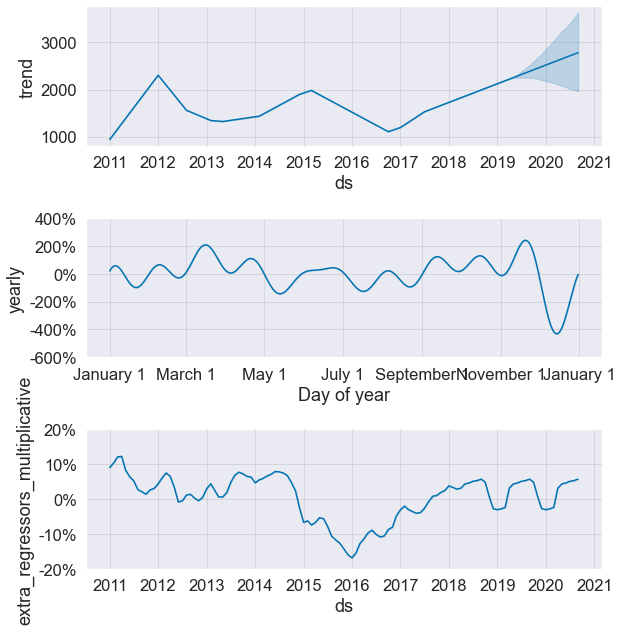

In [45]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

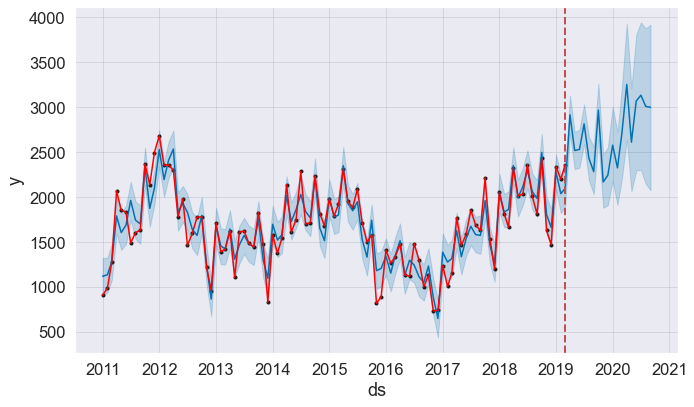

In [46]:
fig = m.plot(forecast, uncertainty=True)
plt.axvline(df['ds'].iloc[df.shape[0]-1], color='r', linestyle='--', lw=2)
plt.plot(df['ds'], df['y'], color="red" )

In [47]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

### Evaluate

In [48]:
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(metric_df.yhat.values, metric_df.y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.0843
me     :  0.3457
mae    :  124.4716
mpe    :  0.0153
rmse   :  158.0249
corr   :  0.9342
minmax :  0.0763


### next 18 month forecast

In [50]:
forecast.tail(18)[['ds','yhat']]

,ds,yhat
99,2019-04-01,2913.847973
100,2019-05-01,2517.407804
101,2019-06-01,2527.993299
102,2019-07-01,2812.965193
103,2019-08-01,2430.233013
104,2019-09-01,2282.417843
105,2019-10-01,2965.761575
106,2019-11-01,2166.959331
107,2019-12-01,2241.803120
108,2020-01-01,2576.320585


### 3. SARIMAX Model (Future Work)

ACF plot: is a bar chart of the coefficients of correlation between a time series and its lags. It helps determine the value of p or the AR term.

PACF plot: a plot of the partial correlation coefficients between the series and lags of itself. Helps determine the value of q or the MA term


In [79]:
df=df.rename(columns = {'ds':'Month','y':'Customer Volumes'})

df = df.set_index('Month')

### First order difference 

In [81]:
df_differenced_all = df.diff().dropna()

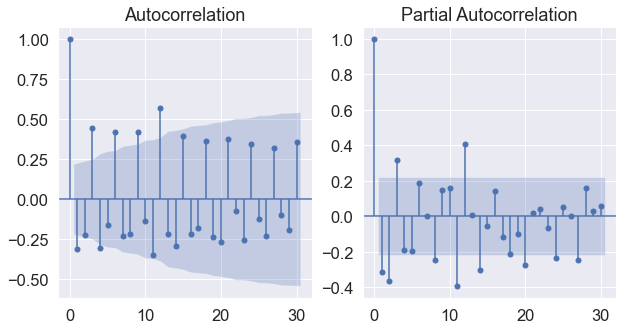

In [82]:
#Correlograms
fig,ax= plt.subplots(1,2, figsize=(10,5))
plot_acf(df_differenced['Customer Volumes'], lags = 30, ax= ax[0])
plot_pacf(df_differenced['Customer Volumes'], lags=30, ax=ax[1])
plt.show()

### Split data into Train and Test

In [83]:
n_obs=18

df_train, df_test = df[0:-n_obs], df[-n_obs:]
print(df_train.shape, df_test.shape)

(81, 4) (18, 4)


In [84]:
train_X, train_y = df_train.loc[:, df_train.columns != 'Customer Volumes'], df_train[['Customer Volumes']]
test_X, test_y = df_test.loc[:, df_test.columns != 'Customer Volumes'], df_test[['Customer Volumes']]

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
         exog=train_X,
         order=(0,1,1),
         enforce_invertibility=False, enforce_stationarity=False)

In [86]:
# fit model
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94711D+00    |proj g|=  9.87952D-02

At iterate    5    f=  6.94205D+00    |proj g|=  5.41218D-03

At iterate   10    f=  6.93856D+00    |proj g|=  6.66547D-02

At iterate   15    f=  6.93543D+00    |proj g|=  3.97265D-04

At iterate   20    f=  6.93524D+00    |proj g|=  2.97382D-03

At iterate   25    f=  6.93519D+00    |proj g|=  6.04773D-05

At iterate   30    f=  6.93513D+00    |proj g|=  2.01383D-03

At iterate   35    f=  6.93501D+00    |proj g|=  3.51973D-04

At iterate   40    f=  6.93501D+00    |proj g|=  2.41469D-04

At iterate   45    f=  6.93499D+00    |proj g|=  3.54303D-03

At iterate   50    f=  6.93426D+00    |proj g|=  1.72219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


In [88]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
                     start_p=1,  
                     start_q=1, 
                     max_p=12,  
                     max_q=12, 
                     d=1, 
                     max_d=12,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1162.490, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1170.670, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1164.710, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1160.541, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1168.721, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1162.277, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1159.737, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1132.699, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1151.829, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1134.825, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1159.273, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1151.023, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1136.292, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : 

In [89]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   81
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -560.369
Date:                Mon, 05 Jul 2021   AIC                           1130.738
Time:                        19:49:44   BIC                           1142.648
Sample:                             0   HQIC                          1135.513
                                 - 81                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9767      0.035    -27.810      0.000      -1.045      -0.908
ar.L2         -0.9916      0.017    -58.730      0.000      -1.025      -0.959
ma.L1          0.8776      0.078     11.216      0.000       0.724       1.031
ma.L2          0.9116      0.112      8.139      0.000       0.692       1.131
sigma2      6.846e+04   1.02e+04      6.732      0.000    4.85e+04    8.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.50   Prob(JB):                         0.16
Heteroskedasticity (H):               0.29   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
model= SARIMAX(train_y,            
              order=(2,1,2),
              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67940D+00    |proj g|=  2.11675D-01

At iterate    5    f=  6.64110D+00    |proj g|=  1.13861D-01

At iterate   10    f=  6.63112D+00    |proj g|=  1.11260D-01

At iterate   15    f=  6.63091D+00    |proj g|=  3.92472D-03

At iterate   20    f=  6.63091D+00    |proj g|=  6.67251D-04

At iterate   25    f=  6.63089D+00    |proj g|=  1.46211D-02

At iterate   30    f=  6.62939D+00    |proj g|=  1.11172D-01

At iterate   35    f=  6.62450D+00    |proj g|=  2.32479D-01

At iterate   40    f=  6.61902D+00    |proj g|=  3.65190D-01

At iterate   45    f=  6.61695D+00    |proj g|=  5.06447D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


In [91]:
train_size = len(df_train)
test_size = len(df_test)

In [92]:
forecast_1= results.forecast(steps=test_size, exog=test_X)

In [93]:
df_forecast_sarimax = pd.DataFrame(forecast_1)
df_forecast_sarimax

,predicted_mean
2017-10-01,2022.326605
2017-11-01,1725.845836
2017-12-01,1621.731132
2018-01-01,2023.248194
2018-02-01,1731.248812
2018-03-01,1615.462595
2018-04-01,2024.002280
2018-05-01,1736.817015
2018-06-01,1609.199453
2018-07-01,2024.584620


<AxesSubplot:xlabel='Month'>

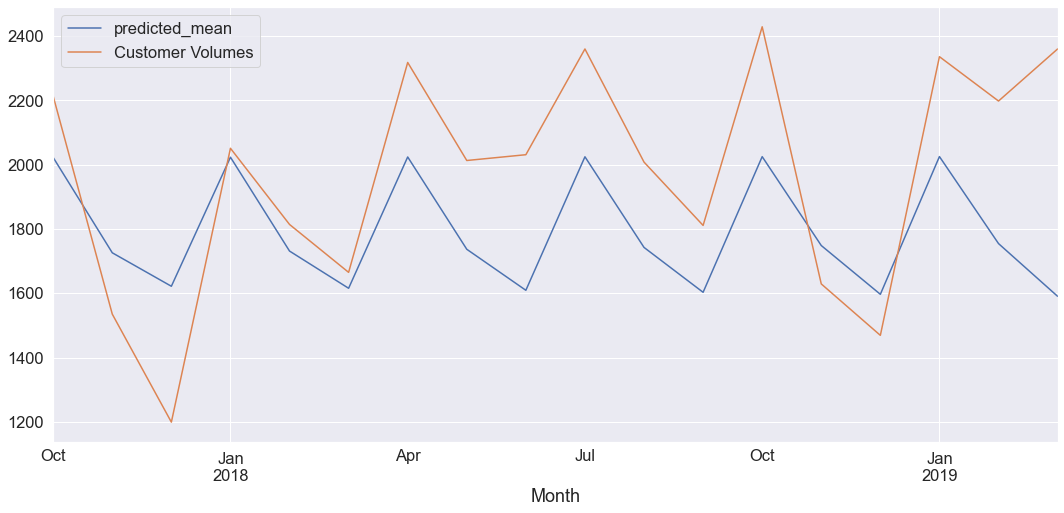

In [94]:
df_forecast_sarimax['predicted_mean'].plot(legend=True)
df_test['Customer Volumes'].plot(legend=True)

### Evaluate

In [95]:
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(df_forecast_sarimax['predicted_mean'].values, df_test['Customer Volumes'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Customer Volumes
mape   :  0.1389
me     :  -178.8153
mae    :  274.4522
mpe    :  -0.0681
rmse   :  325.5463
corr   :  0.6411
minmax :  0.1324


### Next 18 month forecast

In [96]:
X,y = df.loc[:, df.columns != 'Customer Volumes'], df[['Customer Volumes']]

In [97]:
#retrain model with all historical 
model= SARIMAX(y, 
         exog= X,
         order=(2,1,1),
         enforce_invertibility=False, enforce_stationarity=False)

In [98]:
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90540D+00    |proj g|=  1.57814D-01

At iterate    5    f=  6.88531D+00    |proj g|=  3.54276D-03

At iterate   10    f=  6.88230D+00    |proj g|=  6.38683D-02

At iterate   15    f=  6.87359D+00    |proj g|=  8.75068D-03

At iterate   20    f=  6.87351D+00    |proj g|=  3.17355D-03

At iterate   25    f=  6.87314D+00    |proj g|=  5.90628D-03

At iterate   30    f=  6.87310D+00    |proj g|=  1.00003D-03

At iterate   35    f=  6.87123D+00    |proj g|=  2.24568D-02

At iterate   40    f=  6.86892D+00    |proj g|=  2.60118D-03

At iterate   45    f=  6.86890D+00    |proj g|=  9.16370D-04

At iterate   50    f=  6.86870D+00    |proj g|=  2.00770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


In [102]:
indexes

,Type,IDX1,IDX2,IDX3
Month,,,,
2011-01-01,Closed Month,92.690595,108.008014,101.2842
2011-02-01,Closed Month,97.914192,102.123691,101.3352
2011-03-01,Closed Month,108.645217,101.238374,101.2392
2011-04-01,Closed Month,116.243167,109.568848,100.9917
2011-05-01,Closed Month,108.068513,110.511852,100.5940
...,...,...,...,...
2020-05-01,Forecast,73.430000,76.350810,101.1529
2020-06-01,Forecast,71.976667,78.177719,101.2577
2020-07-01,Forecast,72.666667,77.171765,101.3142


In [103]:
X_18 = indexes[indexes['Type']=='Forecast'][['IDX1','IDX2','IDX3']]

In [104]:
forecast_18= results.forecast(steps=18, exog=X_18)
df_forecast_18 = pd.DataFrame(forecast_18)
df_forecast_18

,predicted_mean
2019-04-01,2520.618344
2019-05-01,2279.080149
2019-06-01,2332.193574
2019-07-01,2426.457452
2019-08-01,2223.051364
2019-09-01,2242.895658
2019-10-01,2286.489538
2019-11-01,1987.140218
2019-12-01,1992.139111
2020-01-01,2199.566216
